# NFL Home Win Prediction

This project involves predicting the home wins that a team will have in a season using the following data:

-NFL stats from a JSON feed  on NFL.com’s live GameCenter page from the 2009 -2018 seasons

-NFL positional spending by team from Spotrac.com

-Gameday weather and conditions from NFLWeather.com




In [598]:
!pip install ipywidgets<7
!pip install IPython<6
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

The system cannot find the file specified.
The system cannot find the file specified.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


# Data Cleaning/Preparation
- Weather and Salary data are being inported and cleaned.

In [599]:
import nfldb
#there are some deprecation warnings that we don't want to print
import warnings
warnings.filterwarnings('ignore')

# import pandas and numpy for 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

# connect to PostgreSQL
import psycopg2
conn=psycopg2.connect("dbname='nfldb' user='postgres' host='localhost' password='' port=5432")

import ipywidgets as widgets
from ipywidgets import interactive, interact, interact_manual
from IPython.display import Image, display, HTML
%matplotlib inline

In [600]:
weather = pd.read_csv('data/weather.csv', sep="\t")

In [601]:
team_salary_cap =pd.read_csv('data/salary_cap.csv', sep="\t")

In [602]:
team_cash_payroll = pd.read_csv('data/cash_payroll.csv', sep="\t")

In [603]:
positional_spending = pd.read_csv('data/position_spending.csv', sep="\t")

In [604]:
weather['Temp_F'] = weather['Temp_F'].str.split("/", n = 1, expand = True)

In [605]:
#Domes usually have a temperature of 70F
weather['Temp_F'] = np.where((weather['Temp_F'].str.contains('DOME', regex=False)) , 70 ,  weather['Temp_F'])

In [606]:
weather['Away Score'] = np.where((weather['Away Score'].str.contains('-', regex=False)) , 10 ,  weather['Away Score'])

In [607]:
weather['Away Score'] = np.where((weather['Away Score'].str.contains('Q4: 17', regex=False)) , 17 ,  weather['Away Score'])

In [608]:
weather['Home Score'] = np.where((weather['Home Score'] == np.nan) , 36 ,  weather['Home Score'])

In [609]:
weather['Home Score'].fillna(0, inplace=True)

In [610]:
weather['Away Score'] = weather['Away Score'].astype(int)
weather['Home Score'] = weather['Home Score'].astype(int)
weather['Temp_F'] = weather['Temp_F'].astype(int)

In [611]:
#Filling NA values for abbreviations
team_salary_cap.loc[team_salary_cap['Team'] == "New York Jets", 'ABV'] = 'NYJ'
team_salary_cap.loc[team_salary_cap['Team'] == "Los Angeles Chargers", 'ABV'] = 'SD'
team_salary_cap.loc[team_salary_cap['Team'] == "San Diego Chargers",'ABV'] = 'SD'
team_salary_cap.loc[team_salary_cap['Team'] == "Kansas City Chiefs",'ABV'] = 'KC'
team_salary_cap.loc[team_salary_cap['Team'] == "Green Bay Packers",'ABV'] = 'GB'
team_salary_cap.loc[team_salary_cap['Team'] == "New York Giants",'ABV'] = 'NYG'
team_salary_cap.loc[team_salary_cap['Team'] == "New Orleans Saints",'ABV'] = 'NO'
team_salary_cap.loc[team_salary_cap['Team'] == "Los Angeles Rams",'ABV'] = 'STL'
team_salary_cap.loc[team_salary_cap['Team'] == "St. Louis Rams",'ABV'] = 'STL'
team_salary_cap.loc[team_salary_cap['Team'] == "New England Patriots",'ABV'] = 'NE'
team_salary_cap.loc[team_salary_cap['Team'] == "Tampa Bay Buccaneers",'ABV'] = 'TB'

In [612]:
team_salary_cap = team_salary_cap[team_salary_cap['Team'] != 'Houston Oilers']

In [613]:
unique_team_list = team_salary_cap.groupby(['Team', 'ABV']).size().reset_index(name='Freq')

In [614]:
team_split = unique_team_list['Team'].str.rsplit(' ', 1 ,expand=True).rename(columns=lambda x: 'col{}'.format(x + 1))

In [615]:
unique_team_list['Place'] = team_split['col1']
unique_team_list['Team'] = team_split['col2']

In [616]:
unique_team_list= unique_team_list.drop(['Place', 'Freq'], axis = 1)

In [617]:
aggregation_functions = {'ABV': 'first'}

In [618]:
unique_team_list = unique_team_list.groupby(unique_team_list['Team']).aggregate(aggregation_functions)

In [619]:
unique_team_list_2 = team_salary_cap.groupby(['Team', 'ABV','Year']).size().reset_index(name='Freq')

In [620]:
weather = weather.merge(unique_team_list, how='left', left_on ='Away Team', right_on='Team')

In [621]:
weather = weather.rename(columns ={'ABV' : 'Away ABV'})

In [622]:
weather = weather.merge(unique_team_list, how='left', left_on ='Home Team', right_on='Team')

In [623]:
weather = weather.rename(columns ={'ABV' : 'Home ABV'})

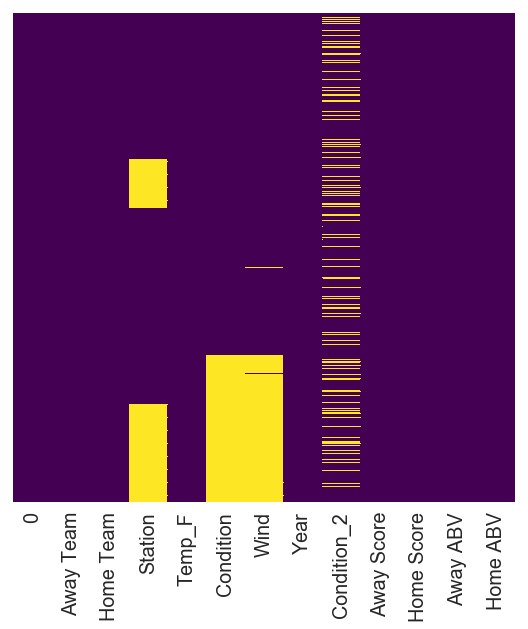

In [624]:
#Looking for null values
sns.set(rc={'figure.figsize':(9,9)}, font_scale=3)
sns.set(font_scale=1.8)
sns.heatmap(weather.isnull(),yticklabels=False, cbar=False,cmap='viridis')

In [625]:
# Combining similar weather conditions
weather.loc[(weather['Condition_2'].str.contains('shower', regex=False, na=False)) | (weather['Condition_2'].str.contains('Shower', regex=False, na=False)), 'Condition_2'] = 'rain'
weather.loc[(weather['Condition_2'].str.contains('sunny', regex=False, na=False)) | (weather['Condition_2'].str.contains('Sunny', regex=False, na=False)), 'Condition_2'] = 'sunny'
weather.loc[(weather['Condition_2'].str.contains('rain', regex=False, na=False)) | (weather['Condition_2'].str.contains('Rain', regex=False, na=False)) | (weather['Condition_2'].str.contains('drizzle', regex=False, na=False)) | (weather['Condition_2'].str.contains('Drizzle', regex=False, na=False)) | (weather['Condition_2'].str.contains('thunderstorm', regex=False, na=False)) | (weather['Condition_2'].str.contains('sprinkle', regex=False, na=False)) |  (weather['Condition_2'].str.contains('Thunderstorm', regex=False, na=False)), 'Condition_2'] = 'rain'
weather.loc[(weather['Condition_2'].str.contains('Fog', regex=False, na=False)) | (weather['Condition_2'].str.contains('fog', regex=False, na=False)) | (weather['Condition_2'].str.contains('Foggy', regex=False, na=False)) | (weather['Condition_2'].str.contains('foggy', regex=False, na=False)), 'Condition_2'] = 'fog'
weather.loc[(weather['Condition_2'].str.contains('clear', regex=False, na=False)) | (weather['Condition_2'].str.contains('Clear', regex=False, na=False)) | (weather['Condition_2'].str.contains('Dry', regex=False, na=False)) | (weather['Condition_2'].str.contains('dry', regex=False, na=False)) |  (weather['Condition_2'].str.contains('Fair', regex=False, na=False)), 'Condition_2'] = 'clear'
weather.loc[(weather['Condition_2'].str.contains('snow', regex=False, na=False)) | (weather['Condition_2'].str.contains('Snow', regex=False, na=False)) | (weather['Condition_2'].str.contains('flurries', regex=False, na=False)) | (weather['Condition_2'].str.contains('Flurries', regex=False, na=False)) | (weather['Condition_2'].str.contains('frost', regex=False, na=False)) |  (weather['Condition_2'].str.contains('Blizzard', regex=False, na=False)) | (weather['Condition_2'].str.contains('Wintry', regex=False, na=False)), 'Condition_2'] = 'snow'
weather.loc[(weather['Condition_2'].str.contains('cloudy', regex=False, na=False)) | (weather['Condition_2'].str.contains('Cloudy', regex=False, na=False)) | (weather['Condition_2'].str.contains('Overcast', regex=False, na=False)) | (weather['Condition_2'].str.contains('clouds', regex=False, na=False))| (weather['Condition_2'].str.contains('Clouds', regex=False, na=False)), 'Condition_2'] = 'cloudy'
weather.loc[(weather['Condition_2'].str.contains('Humid', regex=False, na=False)) | (weather['Condition_2'].str.contains('humid', regex=False, na=False)), 'Condition_2'] = 'humid'
weather.loc[(weather['Condition_2'].str.contains('Breezy', regex=False, na=False)), 'Condition_2'] = 'windy'
weather.loc[(weather['Condition_2'].isnull()), 'Condition_2'] = 'Dome'

In [626]:
# Creating dummy values the weather conditions
condition_merge = pd.get_dummies(weather['Condition_2'])

In [627]:
condition_merge.drop(["NA              "], axis = 1, inplace=True)

In [628]:
weather =  pd.concat([weather, condition_merge], axis =1)

In [629]:
weather_combined = weather[['Home ABV','Year','Temp_F']]

In [630]:
weather_combined = weather_combined.groupby(['Home ABV', 'Year'])['Temp_F'].mean().reset_index()

In [631]:
condition_combined = weather[['Home ABV', 'Year','Dome', 'clear', 'cloudy', 'fog','humid', 'rain', 'snow', 'sunny', 'windy']]

In [632]:
condition_combined = condition_combined.groupby(['Home ABV', 'Year'])['Dome', 'clear', 'cloudy', 'fog','humid', 'rain', 'snow', 'sunny', 'windy'].sum().reset_index()


In [633]:
weather_combined = weather_combined.merge(condition_combined, on = ['Home ABV', 'Year'])

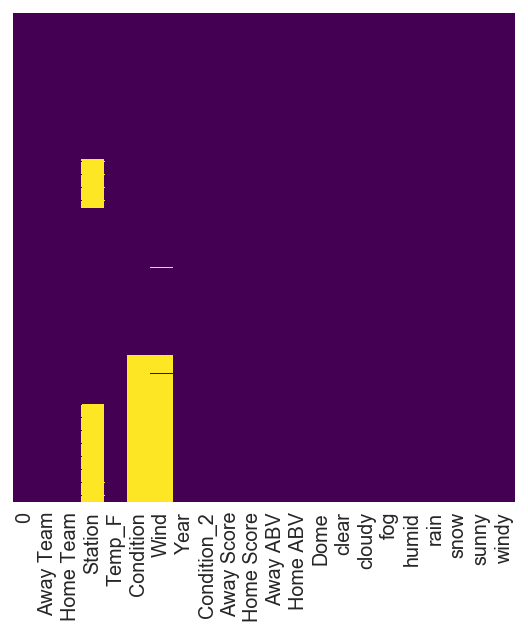

In [634]:
sns.set(rc={'figure.figsize':(9,9)}, font_scale=3)
sns.set(font_scale=1.8)
sns.heatmap(weather.isnull(),yticklabels=False, cbar=False,cmap='viridis')

In [635]:
# Calculating the salary amount per game of each position 
positional_spending['QB $ Per Game'] = positional_spending['QB']/16
positional_spending['RB/FB $ Per Game'] = positional_spending['RB_FB']/16
positional_spending['WR $ Per Game'] = positional_spending['WR']/16
positional_spending['TE $ Per Game'] = positional_spending['TE']/16
positional_spending['OL $ Per Game'] = positional_spending['OL']/16
positional_spending['DL $ Per Game'] = positional_spending['DL']/16
positional_spending['LB $ Per Game'] = positional_spending['LB']/16
positional_spending['DB $ Per Game'] = positional_spending['DB']/16
positional_spending['K/P/LS $ Per Game'] = positional_spending['K_P_LS']/16

In [636]:
positional_spending = positional_spending.merge(unique_team_list_2, how='left', left_on =['0','Year'], right_on=['Team','Year'])

In [637]:
positional_spending = positional_spending[positional_spending['Year'] != 2019]
positional_spending.drop(['0','Freq', 'Unnamed: 0'], axis =1, inplace = True)
t_col_move = positional_spending['Team']
positional_spending.drop(labels=['Team'], axis=1,inplace = True)
positional_spending.insert(0, 'Team', t_col_move)

# Game Results 
- Here a query of the game results dataframe is being ceated. 
- Boolean indicator columns are added for Home Wins, Away Wins, or Ties for each games.

In [638]:
# query game results
game_results=pd.read_sql("""select season_year, week, home_team, home_score, away_team, away_score
from game
where season_type='Regular'""",con=conn)

# replace la with stl & UNK with sd
game_results.replace(to_replace='LA', value='STL', inplace=True)
game_results.replace(to_replace='UNK', value='SD', inplace=True)

# compute wins and ties
game_results['home_win'] = [1 if x>y else 0 for x,y in zip(game_results['home_score'],game_results['away_score'])]
game_results['away_win'] = [1 if x<y else 0 for x,y in zip(game_results['home_score'],game_results['away_score'])]
game_results['tie'] = [1 if x==y else 0 for x,y in zip(game_results['home_score'],game_results['away_score'])]

# sort the dataframe
game_results=game_results.sort_values(by=['season_year','home_team','week'])

# rename the year
game_results=game_results.rename(columns = {'season_year':'year'})

# print first 10 entries
game_results.head(10)

year  week home_team  home_score away_team  away_score  home_win  \
864   2009     1       ARI          16        SF          20         0   
153   2009     3       ARI          10       IND          31         0   
250   2009     5       ARI          28       HOU          21         1   
727   2009     8       ARI          21       CAR          34         0   
281   2009    10       ARI          31       SEA          20         1   
829   2009    13       ARI          30       MIN          17         1   
917   2009    16       ARI          31       STL          10         1   
361   2009    17       ARI           7        GB          33         0   
860   2009     1       ATL          19       MIA           7         1   
1115  2009     2       ATL          28       CAR          20         1   

      away_win  tie  
864          1    0  
153          1    0  
250          0    0  
727          1    0  
281          0    0  
829          0    0  
917          0    0  
361          1    0  
860          0    0  
1115         0    0

In [639]:
game_results = game_results.merge(weather, left_on = ['year','home_team', 'away_team','home_score','away_score'], right_on=['Year','Home ABV','Away ABV', 'Home Score','Away Score'])
game_results.drop(['0','Away Team', 'Home Team', 'Station', 'Condition', 'Wind', 'Year','Away Score','Home Score', 'Away ABV', 'Home ABV'], axis = 1, inplace = True)

In [640]:
game_results = game_results.merge(positional_spending, left_on = ['year','away_team'], right_on=['Year', 'ABV']).rename(columns = {'QB $ Per Game': 'QB $/Game_away','RB/FB $ Per Game': 'RB/FB $/Game_away','WR $ Per Game': 'WR $/Game_away','TE $ Per Game': 'TE $/Game_away','OL $ Per Game': 'OL $/Game_away','DL $ Per Game': 'DL $/Game_away','DB $ Per Game': 'DB $/Game_away', 'K/P/LS $ Per Game': 'K/P/LS $/Game_away', 'LB $ Per Game': 'LB $/Game_away' })
game_results.drop(['Year','Team','Players','QB','RB_FB','WR','TE','OL','DL','LB','DB','K_P_LS','Total','ABV'], axis = 1, inplace = True)

In [641]:
game_results = game_results.merge(positional_spending, left_on = ['year','home_team'], right_on=['Year', 'ABV']).rename(columns = {'QB $ Per Game': 'QB $/Game_home','RB/FB $ Per Game': 'RB/FB $/Game_home','WR $ Per Game': 'WR $/Game_home','TE $ Per Game': 'TE $/Game_home','OL $ Per Game': 'OL $/Game_home','DL $ Per Game': 'DL $/Game_home','DB $ Per Game': 'DB $/Game_home', 'K/P/LS $ Per Game': 'K/P/LS $/Game_home','LB $ Per Game': 'LB $/Game_home' })
game_results.drop(['Year','Team','Players','QB','RB_FB','WR','TE','OL','DL','LB','DB','K_P_LS','Total','ABV'], axis = 1, inplace = True)

In [642]:
# Add the Average Age of a team to the game results dataframe
game_results = game_results.merge(team_salary_cap[['AVG Age','Year','ABV']],left_on=['year','away_team'], right_on=['Year','ABV']).rename(columns= {'AVG Age': 'Avg. Age_away'})
game_results.drop(['Year','ABV'], axis = 1, inplace = True)

In [643]:
game_results = game_results.merge(team_salary_cap[['AVG Age','Year','ABV']],left_on=['year','home_team'], right_on=['Year','ABV']).rename(columns= {'AVG Age': 'Avg. Age_home'})
game_results.drop(['Year','ABV', 'Condition_2'], axis = 1, inplace = True)

In [644]:
# Creating the difference for the positional salaries so the variables will be on similar scales.
game_results['QB Salary_diff'] = game_results['QB $/Game_home'] - game_results['QB $/Game_away']
game_results['RB/FB Salary_diff'] = game_results['RB/FB $/Game_home'] - game_results['RB/FB $/Game_away']
game_results['WR Salary_diff'] = game_results['WR $/Game_home'] - game_results['WR $/Game_away']
game_results['TE Salary_diff'] = game_results['TE $/Game_home'] - game_results['TE $/Game_away']
game_results['OL Salary_diff'] = game_results['OL $/Game_home'] - game_results['OL $/Game_away']
game_results['DL Salary_diff'] = game_results['DL $/Game_home'] - game_results['DL $/Game_away']
game_results['LB Salary_diff'] = game_results['LB $/Game_home'] - game_results['LB $/Game_away']
game_results['DB Salary_diff'] = game_results['DB $/Game_home'] - game_results['DB $/Game_away']
game_results['K/P/LS Salary_diff'] = game_results['K/P/LS $/Game_home'] - game_results['K/P/LS $/Game_away']
game_results['Avg. Age_diff'] = game_results['Avg. Age_home'] - game_results['Avg. Age_away']

# Baseline
- Using the ratio of the total home wins to the total NFL games, you get the baseline for the predictive model which is 57.06%.

In [645]:
# total number of games
total_games = len(game_results)
total_games

2557

In [646]:
# total number of home wins
home_wins = game_results.home_win.sum()
home_wins

1459

In [647]:
# total home wins/total number of games
home_win_rate = float(home_wins)/float(total_games)
home_win_rate

0.570590535784122

In [648]:
print("Home Team Win Rate: {:.2f}% ".format(home_win_rate*100))

Home Team Win Rate: 57.06% 


In [649]:
wins = game_results[['home_win','away_win', 'tie']]

In [650]:
wins.rename({'home_win':'Home Win','away_win':'Away Win','tie':'Tie'}, axis = 'columns',inplace = True)

In [651]:
wins_2 = wins.apply(pd.value_counts)

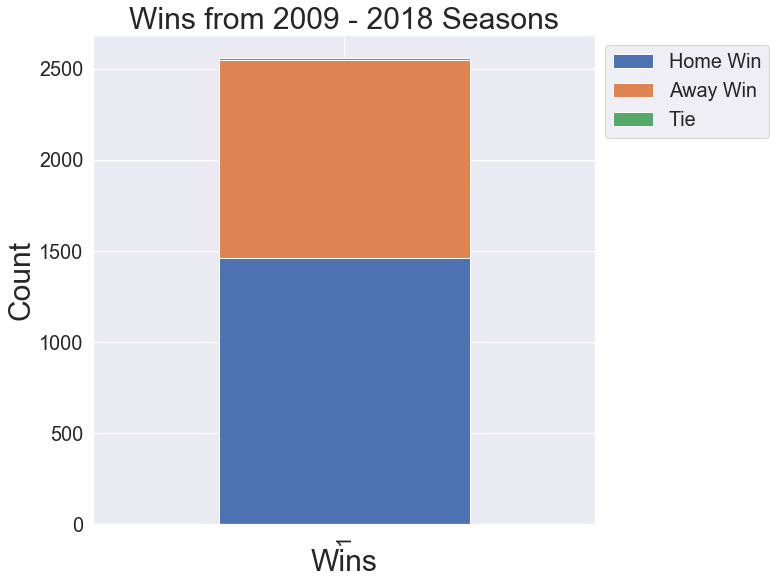

In [652]:

wins_2.loc[[1]].plot(kind='bar', stacked=True).legend(bbox_to_anchor=(1.0, 1))
plt.title('Wins from 2009 - 2018 Seasons', fontsize=30)
plt.xlabel('Wins', fontsize=30)
plt.ylabel('Count', fontsize=30)

plt.savefig('img/hw_ratio.png')

In [653]:
game_home_win = game_results[['home_team','year','home_win']]
game_home_win['game_home_win_cum_sum'] = (game_home_win['home_win'] == 1 )*1
game_home_win['Cumulative Win'] = game_home_win.groupby(['home_team', 'year']).game_home_win_cum_sum.cumsum()
game_home_win.drop(columns=['home_win','game_home_win_cum_sum'], inplace = True)

In [654]:
game_home_win = game_home_win[game_home_win['Cumulative Win'] ==  game_home_win.groupby(['home_team', 'year'])['Cumulative Win'].transform('max')]

In [655]:
game_home_win.drop_duplicates(inplace=True)

# Stats
- Here a query of the stats dataframe is being ceated. 
- Points and turnovers are encoded from the results column.
- The dataframe will then be split into Offensive and Defensive Stats dataframes.
- The chosen stats will be computed in 5 week rolling sums
- Then the the difference between these values for each home nad away team is computed.
- The difference will help the variables be on similar scales.

In [656]:
stats=pd.read_sql("""select drive.pos_team, drive.drive_id, drive.pos_time, drive.first_downs, drive.yards_gained, drive.play_count, drive.result, game.season_year, game.week, game.season_type, game.home_team, game.away_team
from drive
inner join game on drive.gsis_id=game.gsis_id
where season_type='Regular'""",con=conn)

#replace la with stl
stats.replace(to_replace='LA', value='STL', inplace=True)
stats.replace(to_replace='LAC', value='SD', inplace=True)
stats.replace(to_replace='UNK', value='SD', inplace=True)

# encode points results
stats['points'] = [3 if x=="Field Goal" else 7 if x=="Touchdown" else 0 for x in stats['result']]

# encode turnover results
stats['turnover'] = [1 if x==("Interception" or "Fumble" or "Safety" or "Blocked FG" or "Fumble, Safety" or "Blocked Punt" or "Blocked Punt, Downs" or "Blocked FG, Downs") else 0 for x in stats['result']]

# look at the table
stats.head(10)


pos_team  drive_id pos_time  first_downs  yards_gained  play_count  \
0      MIA        16      (2)            0             0           2   
1      PIT         1    (104)            0             2           5   
2      TEN         2    (112)            0             2           4   
3      PIT         3    (184)            1             2           6   
4      TEN         4     (96)            3            55           6   
5      PIT         5    (115)            0            -6           4   
6      TEN         6    (191)            2            35           7   
7      PIT         7     (92)            0             3           3   
8      TEN         8    (122)            1             0           7   
9      PIT         9    (350)            2            53          11   

         result  season_year  week season_type home_team away_team  points  \
0   End of Half         2009     7     Regular       MIA        NO       0   
1          Punt         2009     1     Regular       PIT       TEN       0   
2          Punt         2009     1     Regular       PIT       TEN       0   
3          Punt         2009     1     Regular       PIT       TEN       0   
4     Missed FG         2009     1     Regular       PIT       TEN       0   
5          Punt         2009     1     Regular       PIT       TEN       0   
6  Interception         2009     1     Regular       PIT       TEN       0   
7  Interception         2009     1     Regular       PIT       TEN       0   
8          Punt         2009     1     Regular       PIT       TEN       0   
9          Punt         2009     1     Regular       PIT       TEN       0   

   turnover  
0         0  
1         0  
2         0  
3         0  
4         0  
5         0  
6         1  
7         1  
8         0  
9         0

In [657]:
#add next weeks stats
games_18 = game_results[game_results['year']==2018]

nweek = pd.DataFrame({
        'year': np.array([2018] * 32,dtype='int32'),
        'week': np.array([1] * 32,dtype='int32'),
        'team': np.array((list(set(stats.pos_team))),dtype=str)})

nweek_d = nweek
nweek_o = nweek

# Defensive Statistics

In [658]:

stats_d = stats
stats_d['opp_team'] = np.where(stats_d['pos_team']==stats_d['home_team'], stats_d['away_team'], stats_d['home_team'])
#subset to defensive stats
stats_d = stats_d[['season_year','week','opp_team','yards_gained','points','turnover']]
# rename columns
stats_d.columns = ['year','week','team','yards_allowed','points_allowed','turnovers_forced']

#add next week
stats_d = stats_d.append(nweek_d)

# aggregate rolling 5 week
## sort at year, team, week
stats_d.sort_values(by=['team','year','week'],inplace=True)
## sum across year team week
stats_d=stats_d.groupby(by=['team','year','week'],as_index=False).sum()
## rolling 5 week lagged
rolling = stats_d.groupby(['team'],as_index=False)['yards_allowed','points_allowed','turnovers_forced'].rolling(5).sum().shift(1).reset_index()
## join together
stats_d=stats_d.join(rolling,lsuffix='_weekly',rsuffix='_rolling')

stats_d.head(10)

team  year  week  points_allowed_weekly  turnovers_forced_weekly  \
0  ARI  2009     1                   20.0                      0.0   
1  ARI  2009     2                   17.0                      1.0   
2  ARI  2009     3                   31.0                      1.0   
3  ARI  2009     5                   21.0                      1.0   
4  ARI  2009     6                    3.0                      1.0   
5  ARI  2009     7                   17.0                      3.0   
6  ARI  2009     8                   27.0                      0.0   
7  ARI  2009     9                   21.0                      1.0   
8  ARI  2009    10                   20.0                      2.0   
9  ARI  2009    11                   13.0                      1.0   

   yards_allowed_weekly  level_0  level_1  yards_allowed_rolling  \
0                 203.0        0        0                    NaN   
1                 367.0        0        1                    NaN   
2                 501.0        0        2                    NaN   
3                 414.0        0        3                    NaN   
4                 128.0        0        4                    NaN   
5                 327.0        0        5                 1613.0   
6                 355.0        0        6                 1737.0   
7                 417.0        0        7                 1725.0   
8                 472.0        0        8                 1641.0   
9                 314.0        0        9                 1699.0   

   points_allowed_rolling  turnovers_forced_rolling  
0                     NaN                       NaN  
1                     NaN                       NaN  
2                     NaN                       NaN  
3                     NaN                       NaN  
4                     NaN                       NaN  
5                    92.0                       4.0  
6                    89.0                       7.0  
7                    99.0                       6.0  
8                    89.0                       6.0  
9                    88.0                       7.0

# Offensive Statistics

In [659]:

stats_o = stats
stats_o=stats_o.rename(columns = {'pos_team':'team'})
stats_o=stats_o.rename(columns = {'season_year':'year'})
stats_o = stats_o[['team','year','week','first_downs','yards_gained','play_count','points','turnover']]

#add next week
stats_o = stats_o.append(nweek_o)

# aggregate rolling 5 week
## sort at year, team, week
stats_o.sort_values(by=['team','year','week'],inplace=True)
## sum across year team week
stats_o=stats_o.groupby(by=['team','year','week'],as_index=False).sum()
## rolling 5 week lagged
rolling = stats_o.groupby(['team'],as_index=False)['first_downs','yards_gained','play_count','points','turnover'].rolling(5).sum().shift(1).reset_index()
## join together
stats_o=stats_o.join(rolling,lsuffix='_weekly',rsuffix='_rolling')

stats_o.head(10)

team  year  week  first_downs_weekly  play_count_weekly  points_weekly  \
0  ARI  2009     1                17.0               99.0           16.0   
1  ARI  2009     2                22.0               89.0           24.0   
2  ARI  2009     3                21.0               97.0           10.0   
3  ARI  2009     5                19.0               81.0           21.0   
4  ARI  2009     6                21.0              100.0           27.0   
5  ARI  2009     7                15.0               88.0           24.0   
6  ARI  2009     8                23.0               91.0           21.0   
7  ARI  2009     9                27.0               91.0           41.0   
8  ARI  2009    10                22.0               98.0           31.0   
9  ARI  2009    11                24.0               90.0           21.0   

   turnover_weekly  yards_gained_weekly  level_0  level_1  \
0              2.0                299.0        0        0   
1              0.0                388.0        0        1   
2              2.0                317.0        0        2   
3              0.0                340.0        0        3   
4              1.0                344.0        0        4   
5              1.0                288.0        0        5   
6              5.0                320.0        0        6   
7              1.0                438.0        0        7   
8              0.0                462.0        0        8   
9              0.0                442.0        0        9   

   first_downs_rolling  yards_gained_rolling  play_count_rolling  \
0                  NaN                   NaN                 NaN   
1                  NaN                   NaN                 NaN   
2                  NaN                   NaN                 NaN   
3                  NaN                   NaN                 NaN   
4                  NaN                   NaN                 NaN   
5                100.0                1688.0               466.0   
6                 98.0                1677.0               455.0   
7                 99.0                1609.0               457.0   
8                105.0                1730.0               451.0   
9                108.0                1852.0               468.0   

   points_rolling  turnover_rolling  
0             NaN               NaN  
1             NaN               NaN  
2             NaN               NaN  
3             NaN               NaN  
4             NaN               NaN  
5            98.0               5.0  
6           106.0               4.0  
7           103.0               9.0  
8           134.0               8.0  
9           144.0               8.0

# Combination of Stats

In [660]:
# drop the level variables from offense and defensive
stats_o = stats_o.drop(['level_0','level_1'], axis=1)
stats_d = stats_d.drop(['level_0','level_1'], axis=1)

# combine offense and defense stats
stats_od=pd.merge(stats_d,stats_o,how='inner',on=['team','year','week'])

# drop the year 2009 becasue of the blank weeks
stats_od=stats_od[stats_od['year']!=2009]

# drop the weekly stats because we won't be needing them
weekly_stats = [col for col in stats_od if col.endswith('weekly')]
stats_od = stats_od.drop(weekly_stats, axis=1)

# convert to numeric
stats_od=stats_od.apply(pd.to_numeric, errors='ignore')

stats_od.head(10)

team  year  week  yards_allowed_rolling  points_allowed_rolling  \
16  ARI  2010     1                 1507.0                    92.0   
17  ARI  2010     2                 1517.0                    88.0   
18  ARI  2010     3                 1634.0                   105.0   
19  ARI  2010     4                 1709.0                   111.0   
20  ARI  2010     5                 1890.0                   135.0   
21  ARI  2010     7                 1903.0                   131.0   
22  ARI  2010     8                 1880.0                   140.0   
23  ARI  2010     9                 1843.0                   123.0   
24  ARI  2010    10                 1993.0                   127.0   
25  ARI  2010    11                 2064.0                   129.0   

    turnovers_forced_rolling  first_downs_rolling  yards_gained_rolling  \
16                      10.0                 91.0                1577.0   
17                      11.0                 92.0                1557.0   
18                       9.0                 92.0                1579.0   
19                       8.0                 89.0                1466.0   
20                       5.0                 73.0                1183.0   
21                       7.0                 72.0                1201.0   
22                       4.0                 64.0                1050.0   
23                       4.0                 75.0                1177.0   
24                       5.0                 70.0                1175.0   
25                       6.0                 79.0                1378.0   

    play_count_rolling  points_rolling  turnover_rolling  
16               404.0           109.0               6.0  
17               406.0            96.0               6.0  
18               406.0            93.0               7.0  
19               397.0            86.0               7.0  
20               369.0            58.0               9.0  
21               385.0            67.0               7.0  
22               374.0            60.0               8.0  
23               393.0            81.0               9.0  
24               392.0            74.0               8.0  
25               410.0            88.0               7.0

# Merging Salary and Weather Data with Home Win Data

In [661]:
mean_stat_o = stats_o.groupby(['team', 'year'])['first_downs_weekly','play_count_weekly', 'points_weekly', 'yards_gained_weekly','turnover_weekly'].mean().reset_index()

In [662]:
mean_stat_d = stats_d.groupby(['team', 'year'])['points_allowed_weekly','turnovers_forced_weekly', 'yards_allowed_weekly'].mean().reset_index()

In [663]:
merge_stats = mean_stat_o.merge(mean_stat_d, on = ['team', 'year'])

In [664]:
merge_stats = merge_stats.merge(game_home_win, left_on=['team','year'], right_on = ['home_team','year'])

In [665]:
merge_stats = merge_stats.merge(weather_combined, left_on=['team','year'], right_on=['Home ABV', 'Year'])

In [666]:
merge_stats.drop(['home_team','Home ABV', 'Year'], axis = 1, inplace = True)

In [667]:
merge_stats = merge_stats.merge(positional_spending, left_on=['team', 'year'], right_on=['ABV','Year'])

In [668]:
merge_stats.head(10)

team  year  first_downs_weekly  play_count_weekly  points_weekly  \
0  ARI  2009             19.8125            87.4375        22.6250   
1  ARI  2010             15.0625            81.9375        14.5625   
2  ARI  2011             17.8750            85.1875        18.0000   
3  ARI  2012             15.3750            87.5000        13.8750   
4  ARI  2013             20.5625            87.7500        21.3750   
5  ARI  2014             18.8750            88.4375        17.2500   
6  ARI  2015             23.3125            90.8750        28.0000   
7  ARI  2016             23.0000            95.6875        24.9375   
8  ARI  2017             19.3750            92.3750        17.8125   
9  ARI  2018             14.9375            80.1875        12.7500   

   yards_gained_weekly  turnover_weekly  points_allowed_weekly  \
0             343.3750           1.1250                18.8750   
1             268.5000           1.1875                25.4375   
2             323.0000           1.4375                20.5625   
3             262.6250           1.3125                18.6875   
4             345.9375           1.3750                19.5625   
5             319.8750           0.7500                18.2500   
6             407.9375           0.8125                19.3125   
7             362.4375           1.0625                21.3125   
8             314.3750           1.1250                21.0625   
9             241.1875           1.1250                24.8125   

   turnovers_forced_weekly  yards_allowed_weekly  ...  QB $ Per Game  \
0                   1.3125              346.0625  ...   9.453125e+05   
1                   1.0625              372.7500  ...   1.597408e+05   
2                   0.6250              353.4375  ...   6.789320e+05   
3                   1.3750              336.5625  ...   7.284681e+05   
4                   1.2500              317.1875  ...   3.858121e+05   
5                   1.1250              367.1875  ...   9.938358e+05   
6                   1.1875              321.0000  ...   7.396355e+05   
7                   0.8750              303.7500  ...   1.310478e+06   
8                   0.9375              311.3750  ...   3.290073e+05   
9                   0.4375              358.1875  ...   3.249745e+05   

   RB/FB $ Per Game  WR $ Per Game  TE $ Per Game  OL $ Per Game  \
0       239854.1250   1.086964e+06     50312.5000   9.698692e+05   
1       242510.3750   9.211177e+05    126015.6250   1.244614e+06   
2       313416.6875   1.270470e+06    280725.3750   1.452917e+06   
3       470808.0000   1.656086e+06    325998.8750   9.258371e+05   
4       331672.1250   9.461541e+05    154358.9375   1.191856e+06   
5       125362.2500   9.175912e+05    294940.9375   8.581234e+05   
6       124433.3750   1.016620e+06    323934.7500   1.781733e+06   
7       222153.9375   1.119496e+06    275804.1875   5.903951e+05   
8        76158.0625   1.306952e+06    345983.0625   4.020112e+05   
9       424744.8125   1.266634e+06    516907.2500   1.626706e+05   

   DL $ Per Game  LB $ Per Game  DB $ Per Game  K/P/LS $ Per Game  ABV  
0   5.332016e+05   6.650644e+05   1.353003e+06        124687.5000  ARI  
1   6.385906e+05   3.415547e+05   1.526365e+06        153437.5000  ARI  
2   7.216229e+05   6.604418e+05   1.421197e+06        235937.5000  ARI  
3   1.015088e+06   8.336656e+05   1.178310e+06        202604.1875  ARI  
4   1.375744e+06   6.951658e+05   8.104271e+05        294791.6250  ARI  
5   1.171998e+06   4.908323e+05   1.234968e+06        116348.6875  ARI  
6   1.387032e+06   5.952078e+05   1.545072e+06        110031.2500  ARI  
7   1.587498e+06   7.150641e+05   1.057516e+06         77237.0000  ARI  
8   7.364216e+05   1.217155e+06   1.840801e+06        275196.6875  ARI  
9   1.409290e+06   8.445917e+05   1.565610e+06        229655.3125  ARI  

[10 rows x 44 columns]

# Visualizations
- Bar plots showing stats, weather, and salary data vs. the total wins for a team in a season.

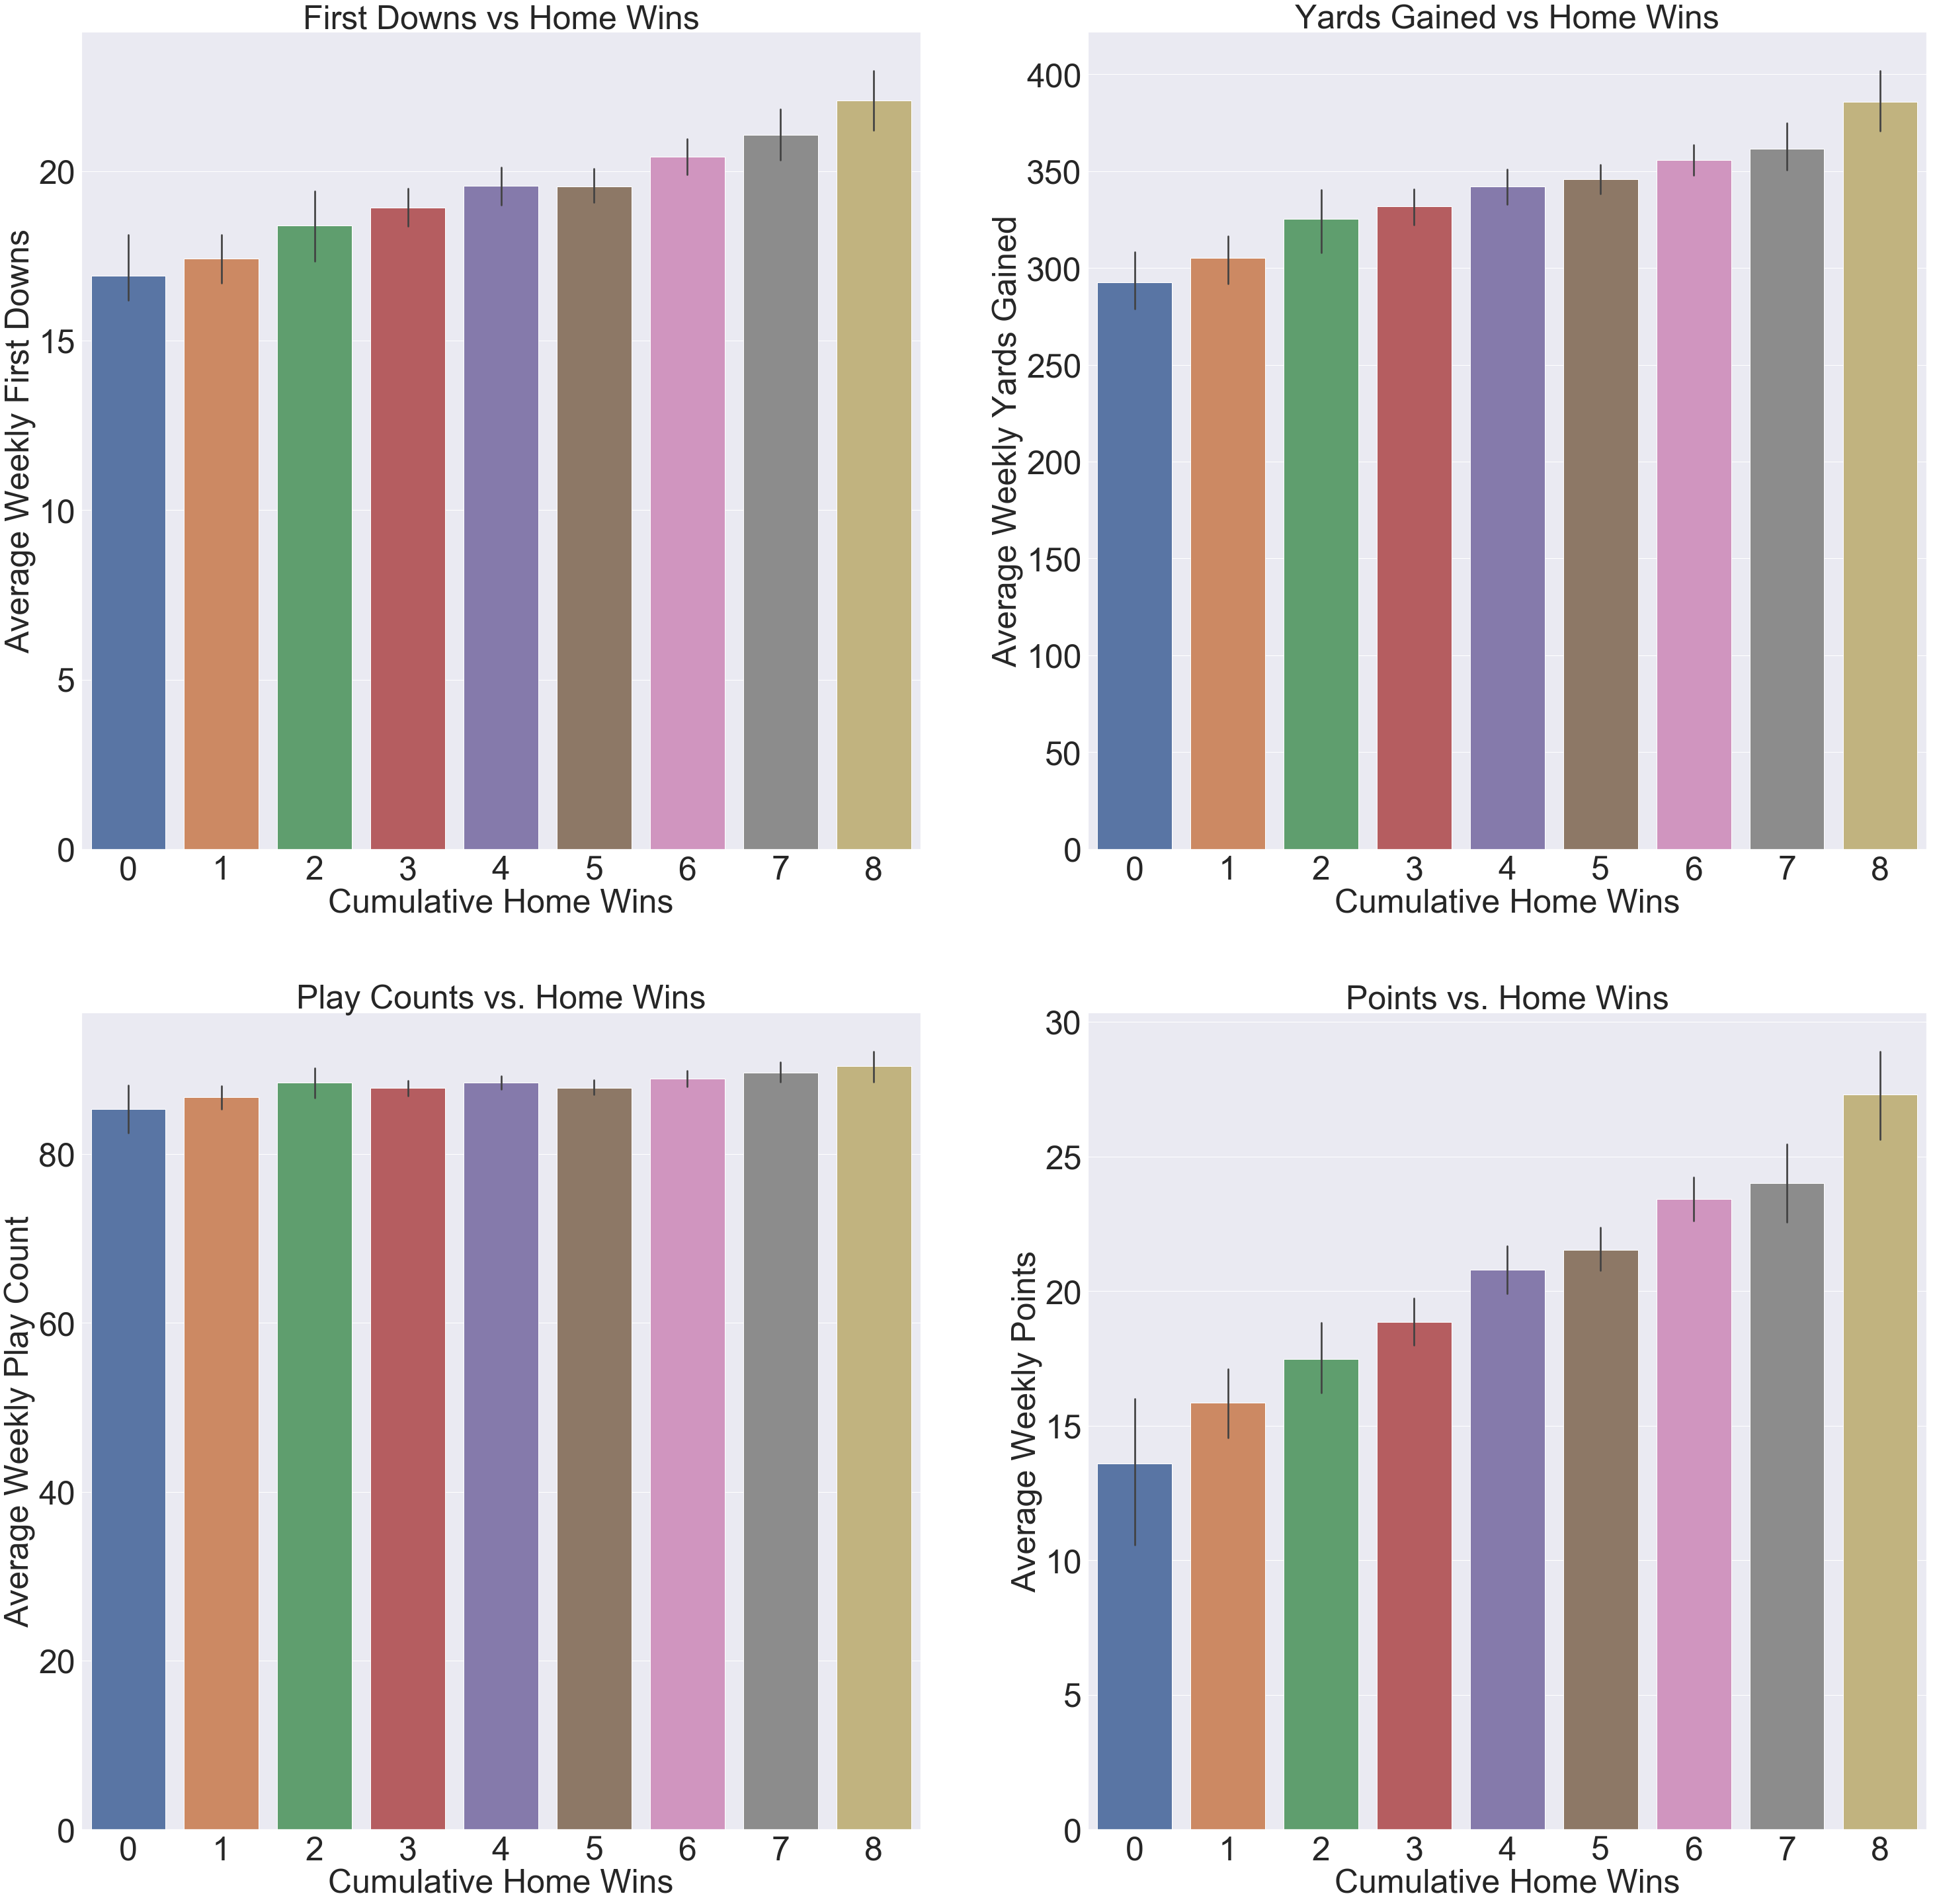

In [669]:
fig = plt.figure(figsize=(50,50))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)



sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['first_downs_weekly'], ax=ax1).set_title("First Downs vs Home Wins", fontsize = 50)
ax1.set_xlabel('Cumulative Home Wins', fontsize = 50)
ax1.set_ylabel('Average Weekly First Downs', fontsize = 50)
ax1.tick_params(labelsize=50)

sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['yards_gained_weekly'], ax=ax2).set_title("Yards Gained vs Home Wins", fontsize = 50)
ax2.set_xlabel('Cumulative Home Wins', fontsize = 50)
ax2.set_ylabel('Average Weekly Yards Gained', fontsize = 50)
ax2.tick_params(labelsize=50)

sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['play_count_weekly'], ax=ax3).set_title("Play Counts vs. Home Wins", fontsize = 50)
ax3.set_xlabel('Cumulative Home Wins', fontsize = 50)
ax3.set_ylabel('Average Weekly Play Count', fontsize = 50)
ax3.tick_params(labelsize=50)

sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['points_weekly'], ax=ax4).set_title("Points vs. Home Wins", fontsize = 50)
ax4.set_xlabel('Cumulative Home Wins', fontsize = 50)
ax4.set_ylabel('Average Weekly Points', fontsize = 50)
ax4.tick_params(labelsize=50)

fig.savefig('img/offense_v_hw.png')

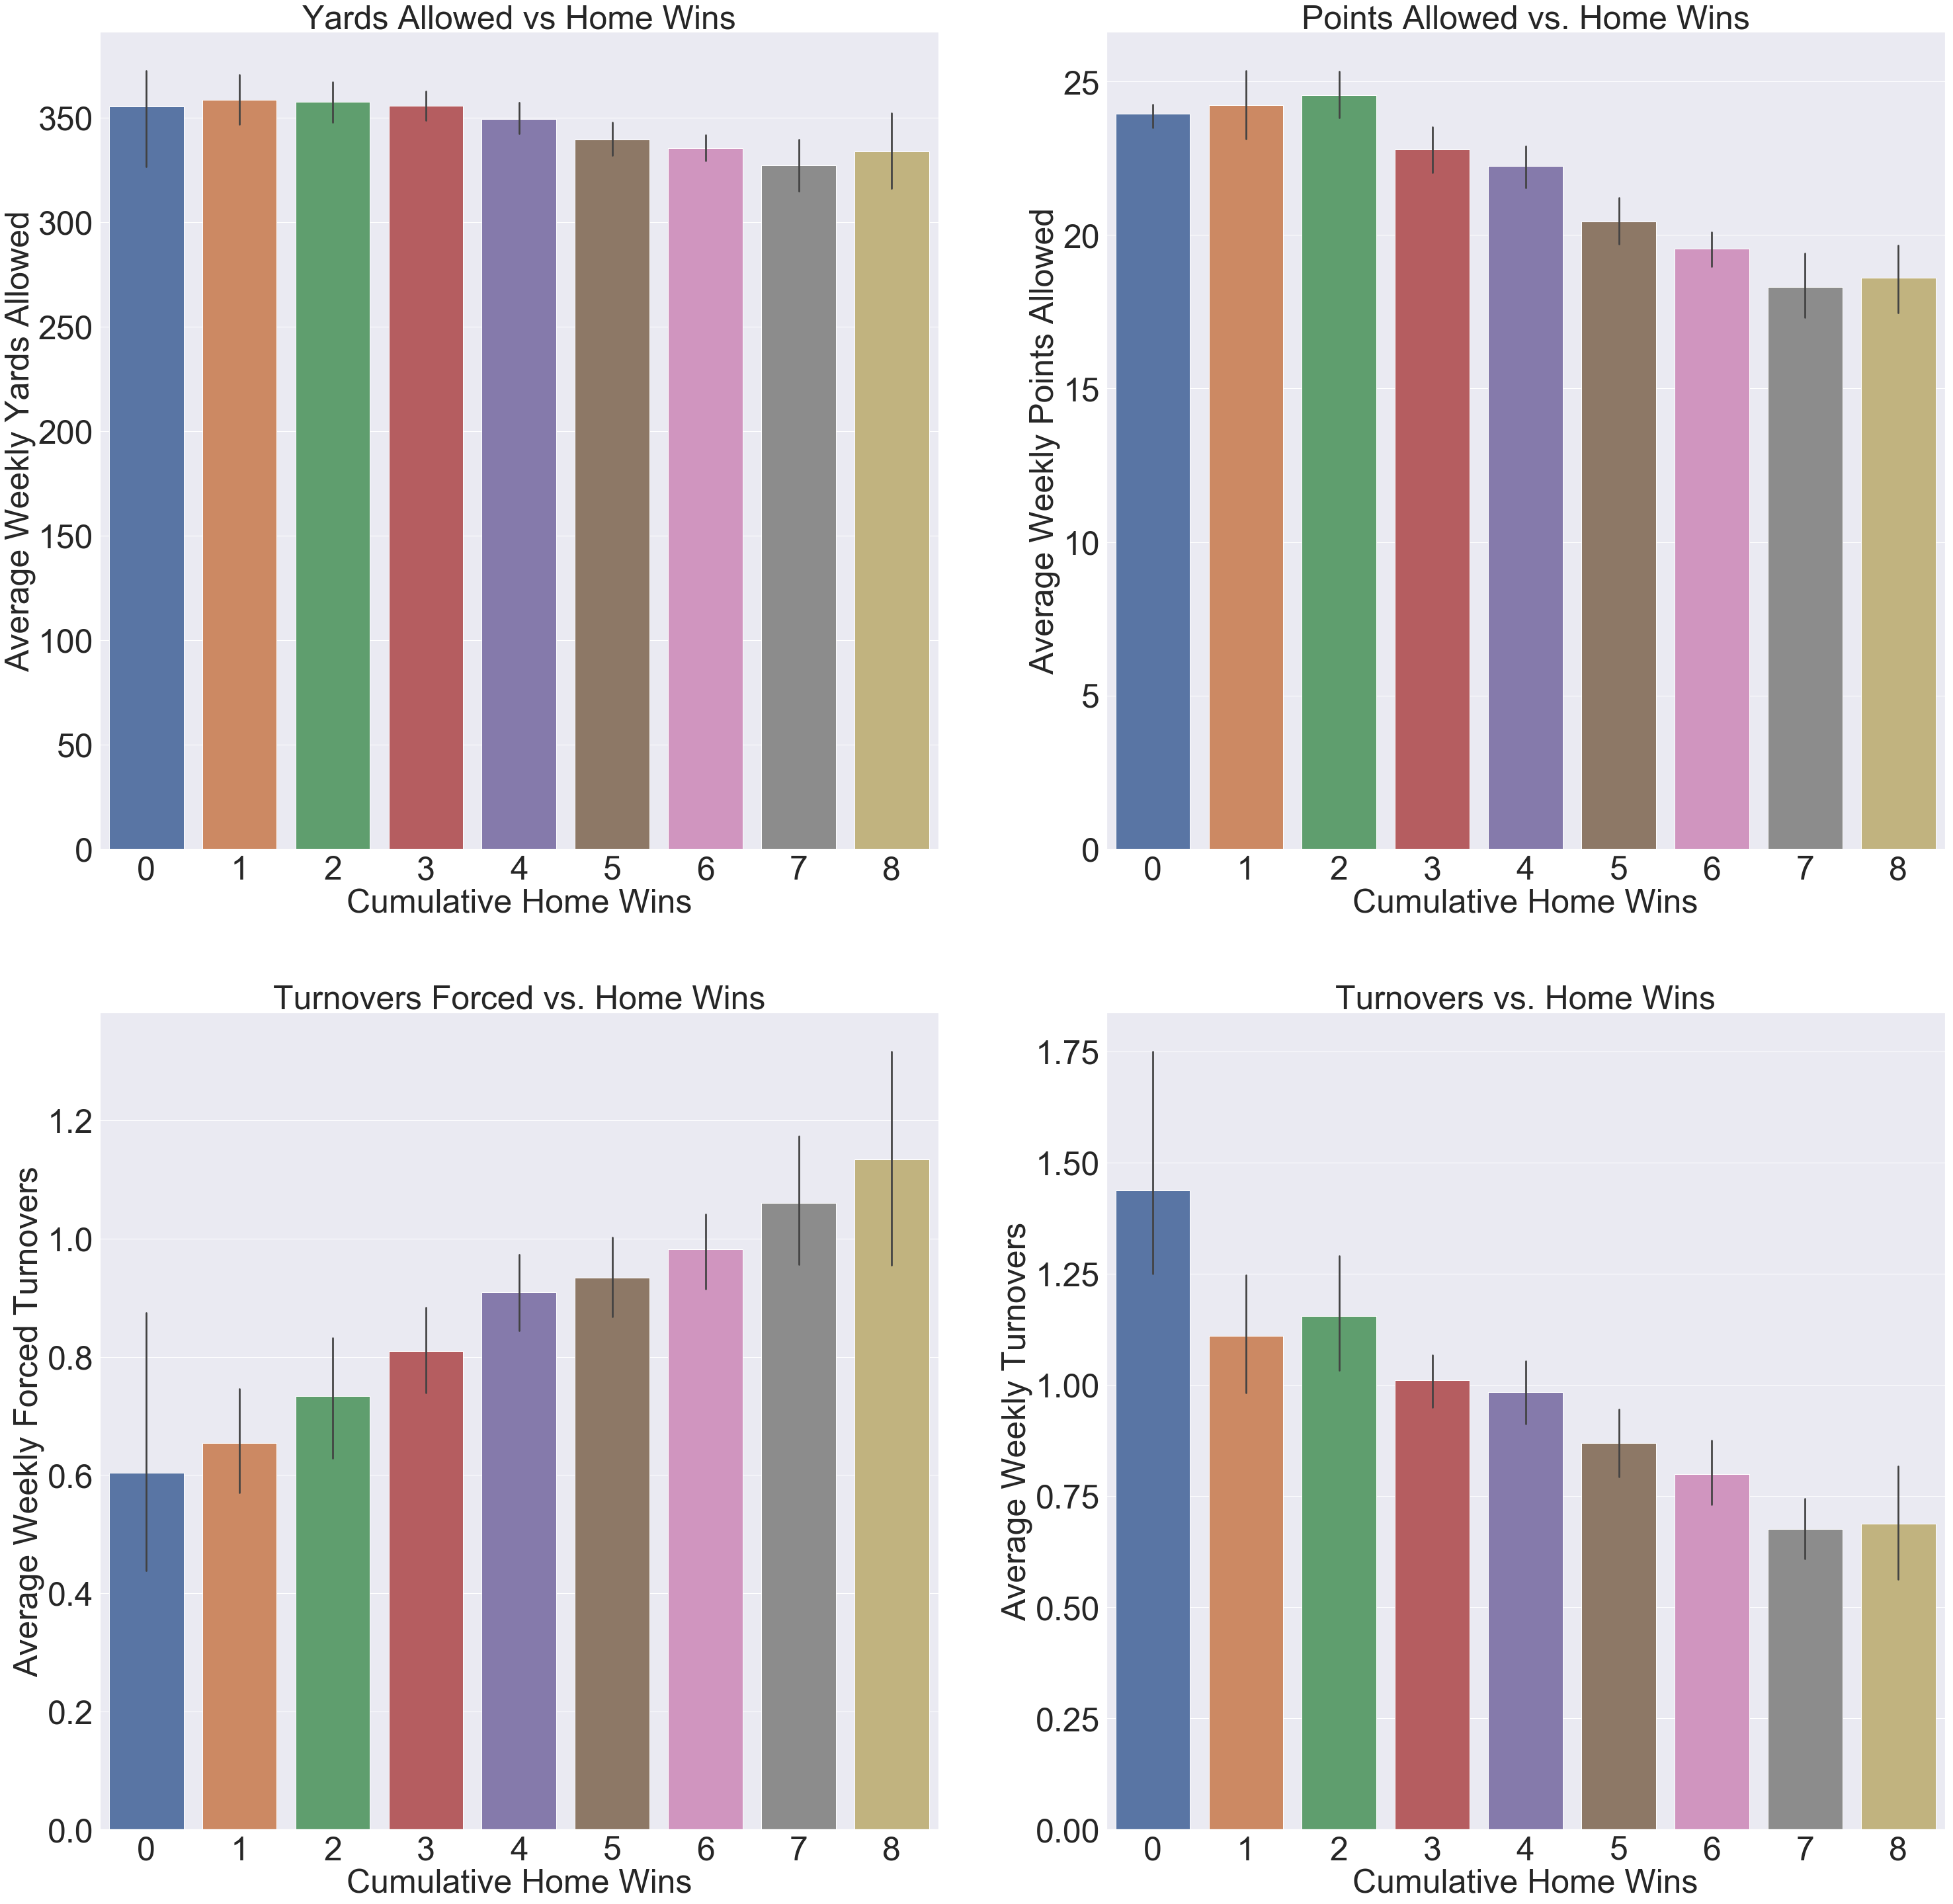

In [670]:
fig = plt.figure(figsize=(50,50))
ax5 = fig.add_subplot(221)
ax6 = fig.add_subplot(222)
ax7 = fig.add_subplot(223)
ax11 = fig.add_subplot(224)

sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['yards_allowed_weekly'], ax=ax5).set_title("Yards Allowed vs Home Wins", fontsize = 50)
ax5.set_xlabel('Cumulative Home Wins', fontsize = 50)
ax5.set_ylabel('Average Weekly Yards Allowed', fontsize = 50)
ax5.tick_params(labelsize=50)

sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['points_allowed_weekly'],  ax=ax6).set_title("Points Allowed vs. Home Wins", fontsize = 50)
ax6.set_xlabel('Cumulative Home Wins', fontsize = 50)
ax6.set_ylabel('Average Weekly Points Allowed', fontsize = 50)
ax6.tick_params(labelsize=50)

sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['turnovers_forced_weekly'],  ax=ax7).set_title("Turnovers Forced vs. Home Wins", fontsize = 50)
ax7.set_xlabel('Cumulative Home Wins', fontsize = 50)
ax7.set_ylabel('Average Weekly Forced Turnovers', fontsize = 50)
ax7.tick_params(labelsize=50)

sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['turnover_weekly'],  ax=ax11).set_title("Turnovers vs. Home Wins", fontsize = 50)
ax11.set_xlabel('Cumulative Home Wins', fontsize = 50)
ax11.set_ylabel('Average Weekly Turnovers', fontsize = 50)
ax11.tick_params(labelsize=50)

fig.savefig('img/defense_v_hw.png')

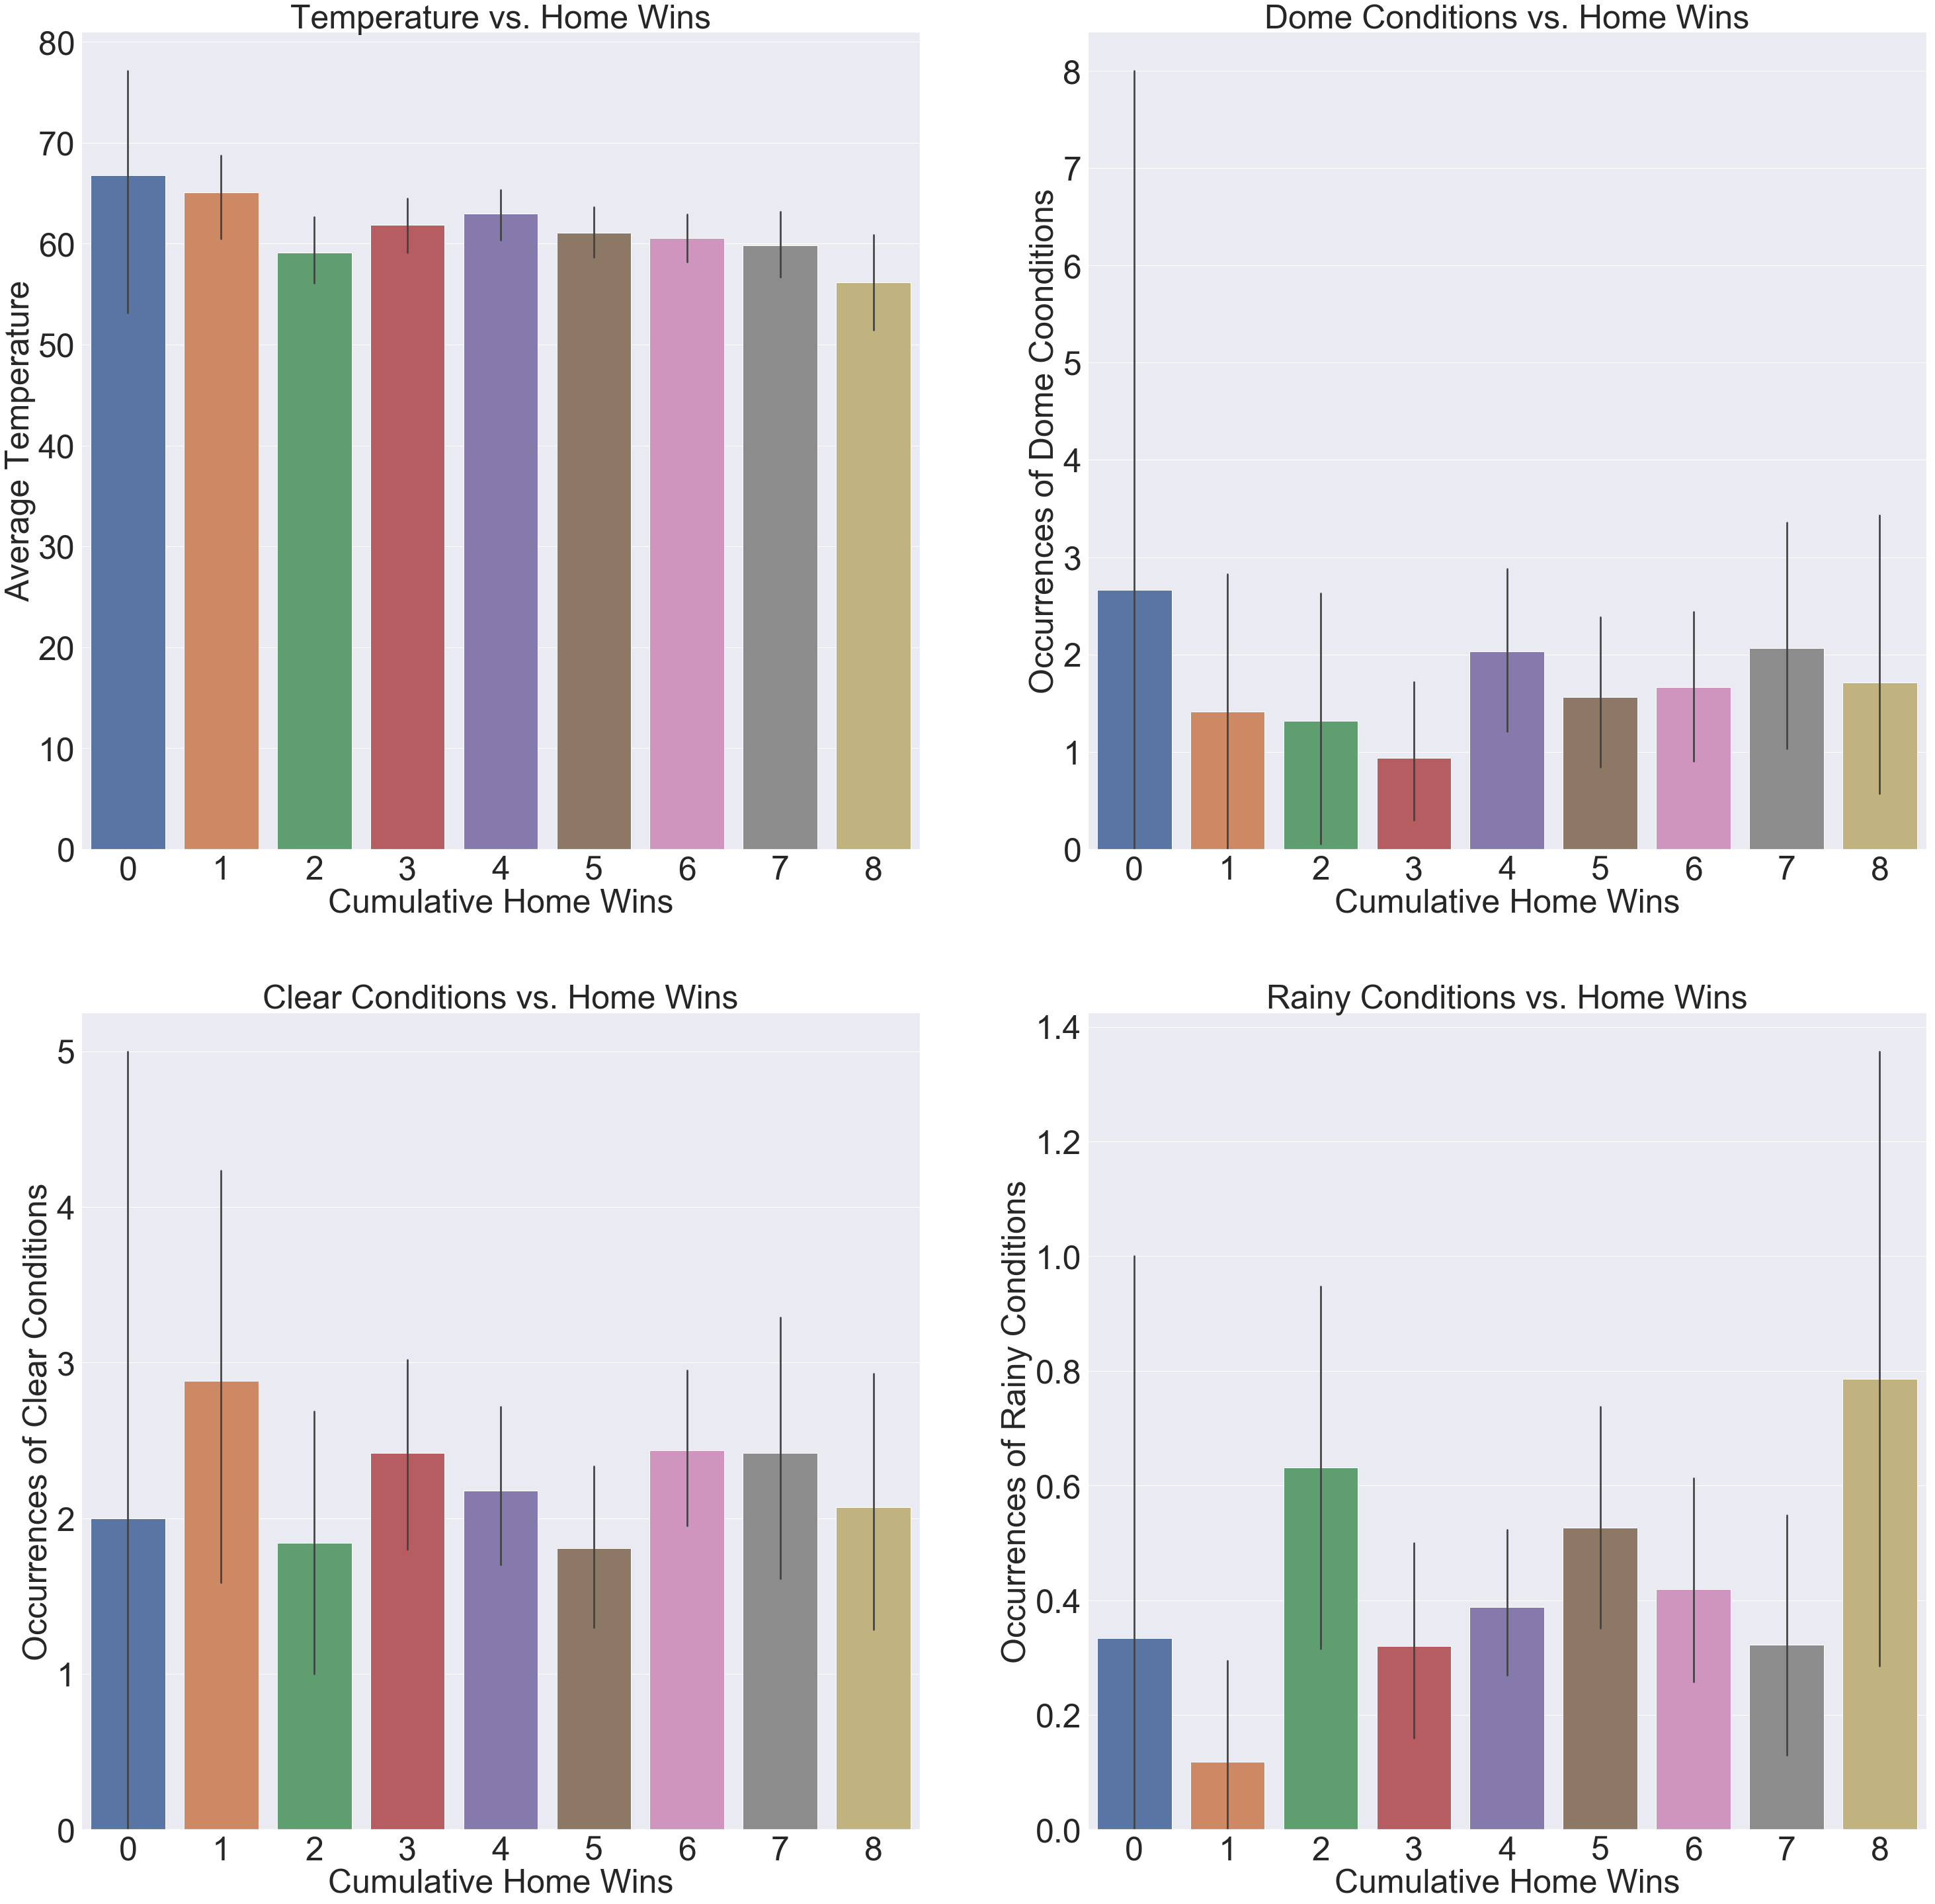

In [671]:
fig = plt.figure(figsize=(50,50))
ax8 = fig.add_subplot(221)
ax9 = fig.add_subplot(222)
ax10 = fig.add_subplot(223)
ax16 = fig.add_subplot(224)

sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['Temp_F'],  ax=ax8).set_title("Temperature vs. Home Wins", fontsize = 50)
ax8.set_xlabel('Cumulative Home Wins', fontsize = 50)
ax8.set_ylabel('Average Temperature', fontsize = 50)
ax8.tick_params(labelsize=50)

sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['Dome'],  ax=ax9).set_title("Dome Conditions vs. Home Wins", fontsize = 50)
ax9.set_xlabel('Cumulative Home Wins', fontsize = 50)
ax9.set_ylabel('Occurrences of Dome Coonditions', fontsize = 50)
ax9.tick_params(labelsize=50)

sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['clear'],  ax=ax10).set_title("Clear Conditions vs. Home Wins", fontsize = 50)
ax10.set_xlabel('Cumulative Home Wins', fontsize = 50)
ax10.set_ylabel('Occurrences of Clear Conditions', fontsize = 50)
ax10.tick_params(labelsize=50)

sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['rain'],  ax=ax16).set_title("Rainy Conditions vs. Home Wins", fontsize = 50)
ax16.set_xlabel('Cumulative Home Wins', fontsize = 50)
ax16.set_ylabel('Occurrences of Rainy Conditions', fontsize = 50)
ax16.tick_params(labelsize=50)

fig.savefig('img/weather_v_hw.png')

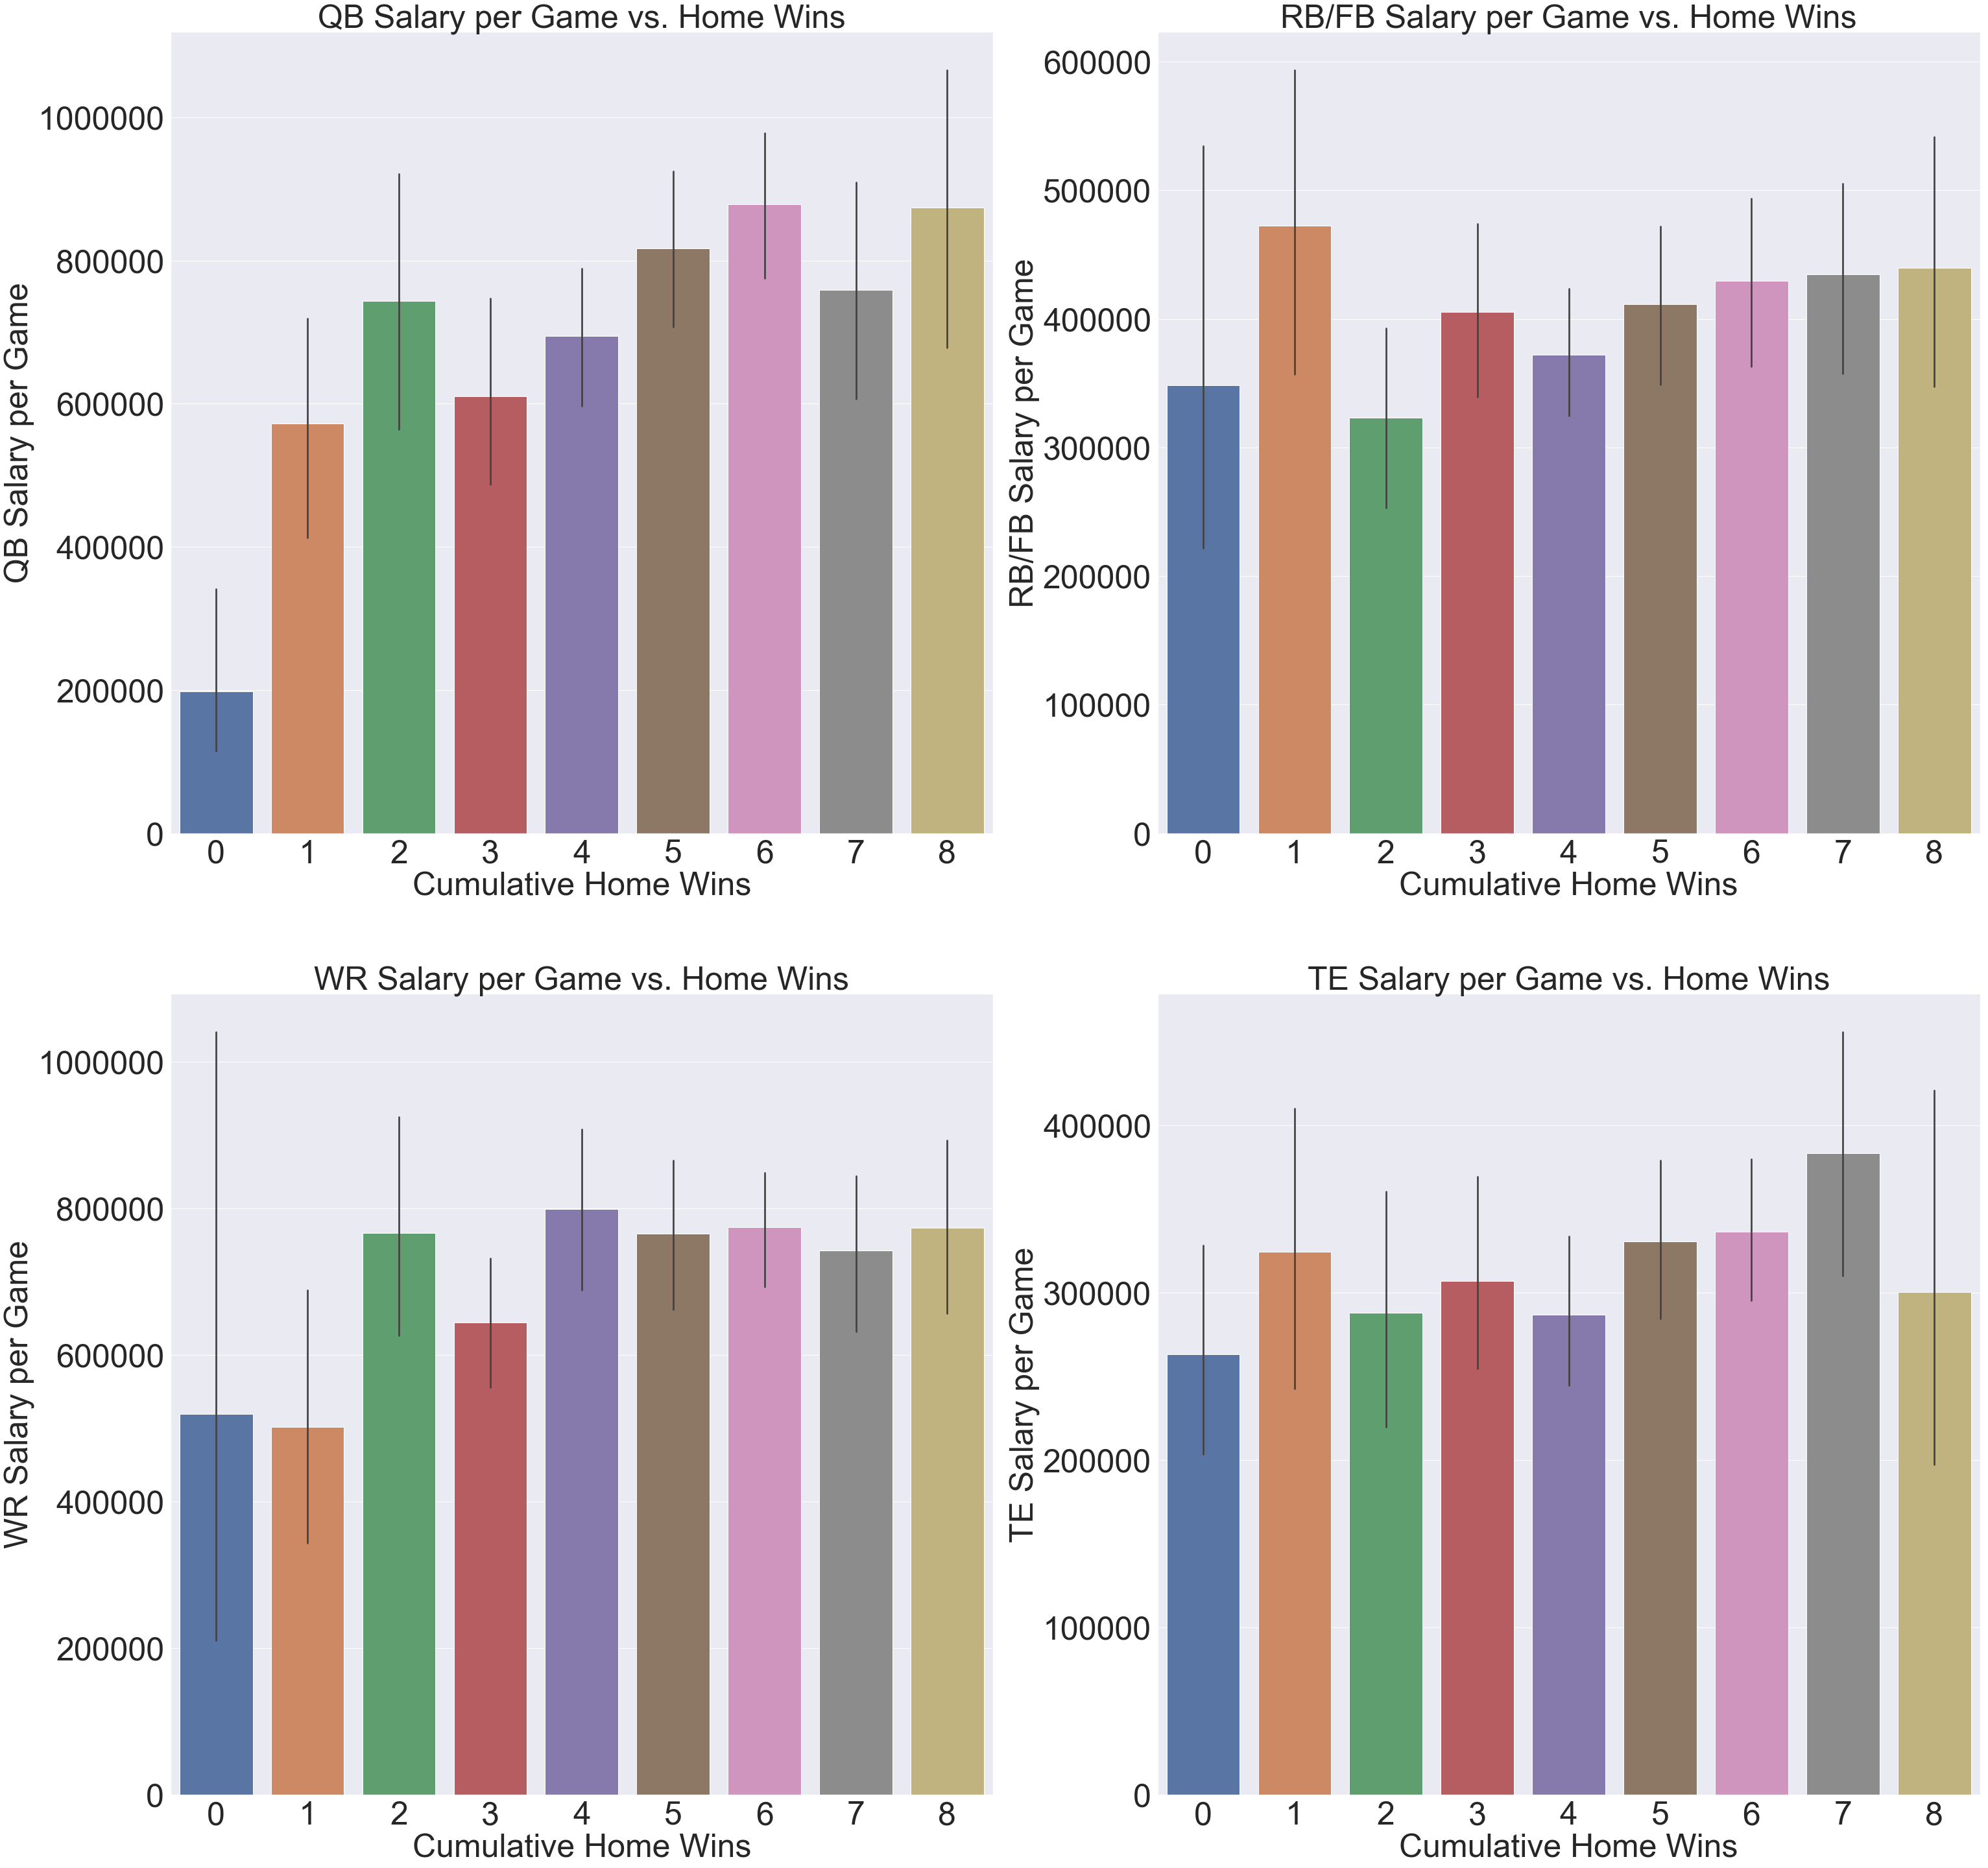

In [672]:
fig = plt.figure(figsize=(50,50))
ax17 = fig.add_subplot(221)
ax18 = fig.add_subplot(222)
ax19 = fig.add_subplot(223)
ax20 = fig.add_subplot(224)


sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['QB $ Per Game'],  ax=ax17).set_title("QB Salary per Game vs. Home Wins", fontsize = 50)
ax17.set_xlabel('Cumulative Home Wins', fontsize = 50)
ax17.set_ylabel('QB Salary per Game', fontsize = 50)
ax17.tick_params(labelsize=50)

sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['RB/FB $ Per Game'],  ax=ax18).set_title("RB/FB Salary per Game vs. Home Wins", fontsize = 50)
ax18.set_xlabel('Cumulative Home Wins', fontsize = 50)
ax18.set_ylabel('RB/FB Salary per Game', fontsize = 50)
ax18.tick_params(labelsize=50)

sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['WR $ Per Game'],  ax=ax19).set_title("WR Salary per Game vs. Home Wins", fontsize = 50)
ax19.set_xlabel('Cumulative Home Wins', fontsize = 50)
ax19.set_ylabel('WR Salary per Game', fontsize = 50)
ax19.tick_params(labelsize=50)

sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['TE $ Per Game'],  ax=ax20).set_title("TE Salary per Game vs. Home Wins", fontsize = 50)
ax20.set_xlabel('Cumulative Home Wins', fontsize = 50)
ax20.set_ylabel('TE Salary per Game', fontsize = 50)
ax20.tick_params(labelsize=50)

fig.savefig('img/o_salary_v_hw.png')

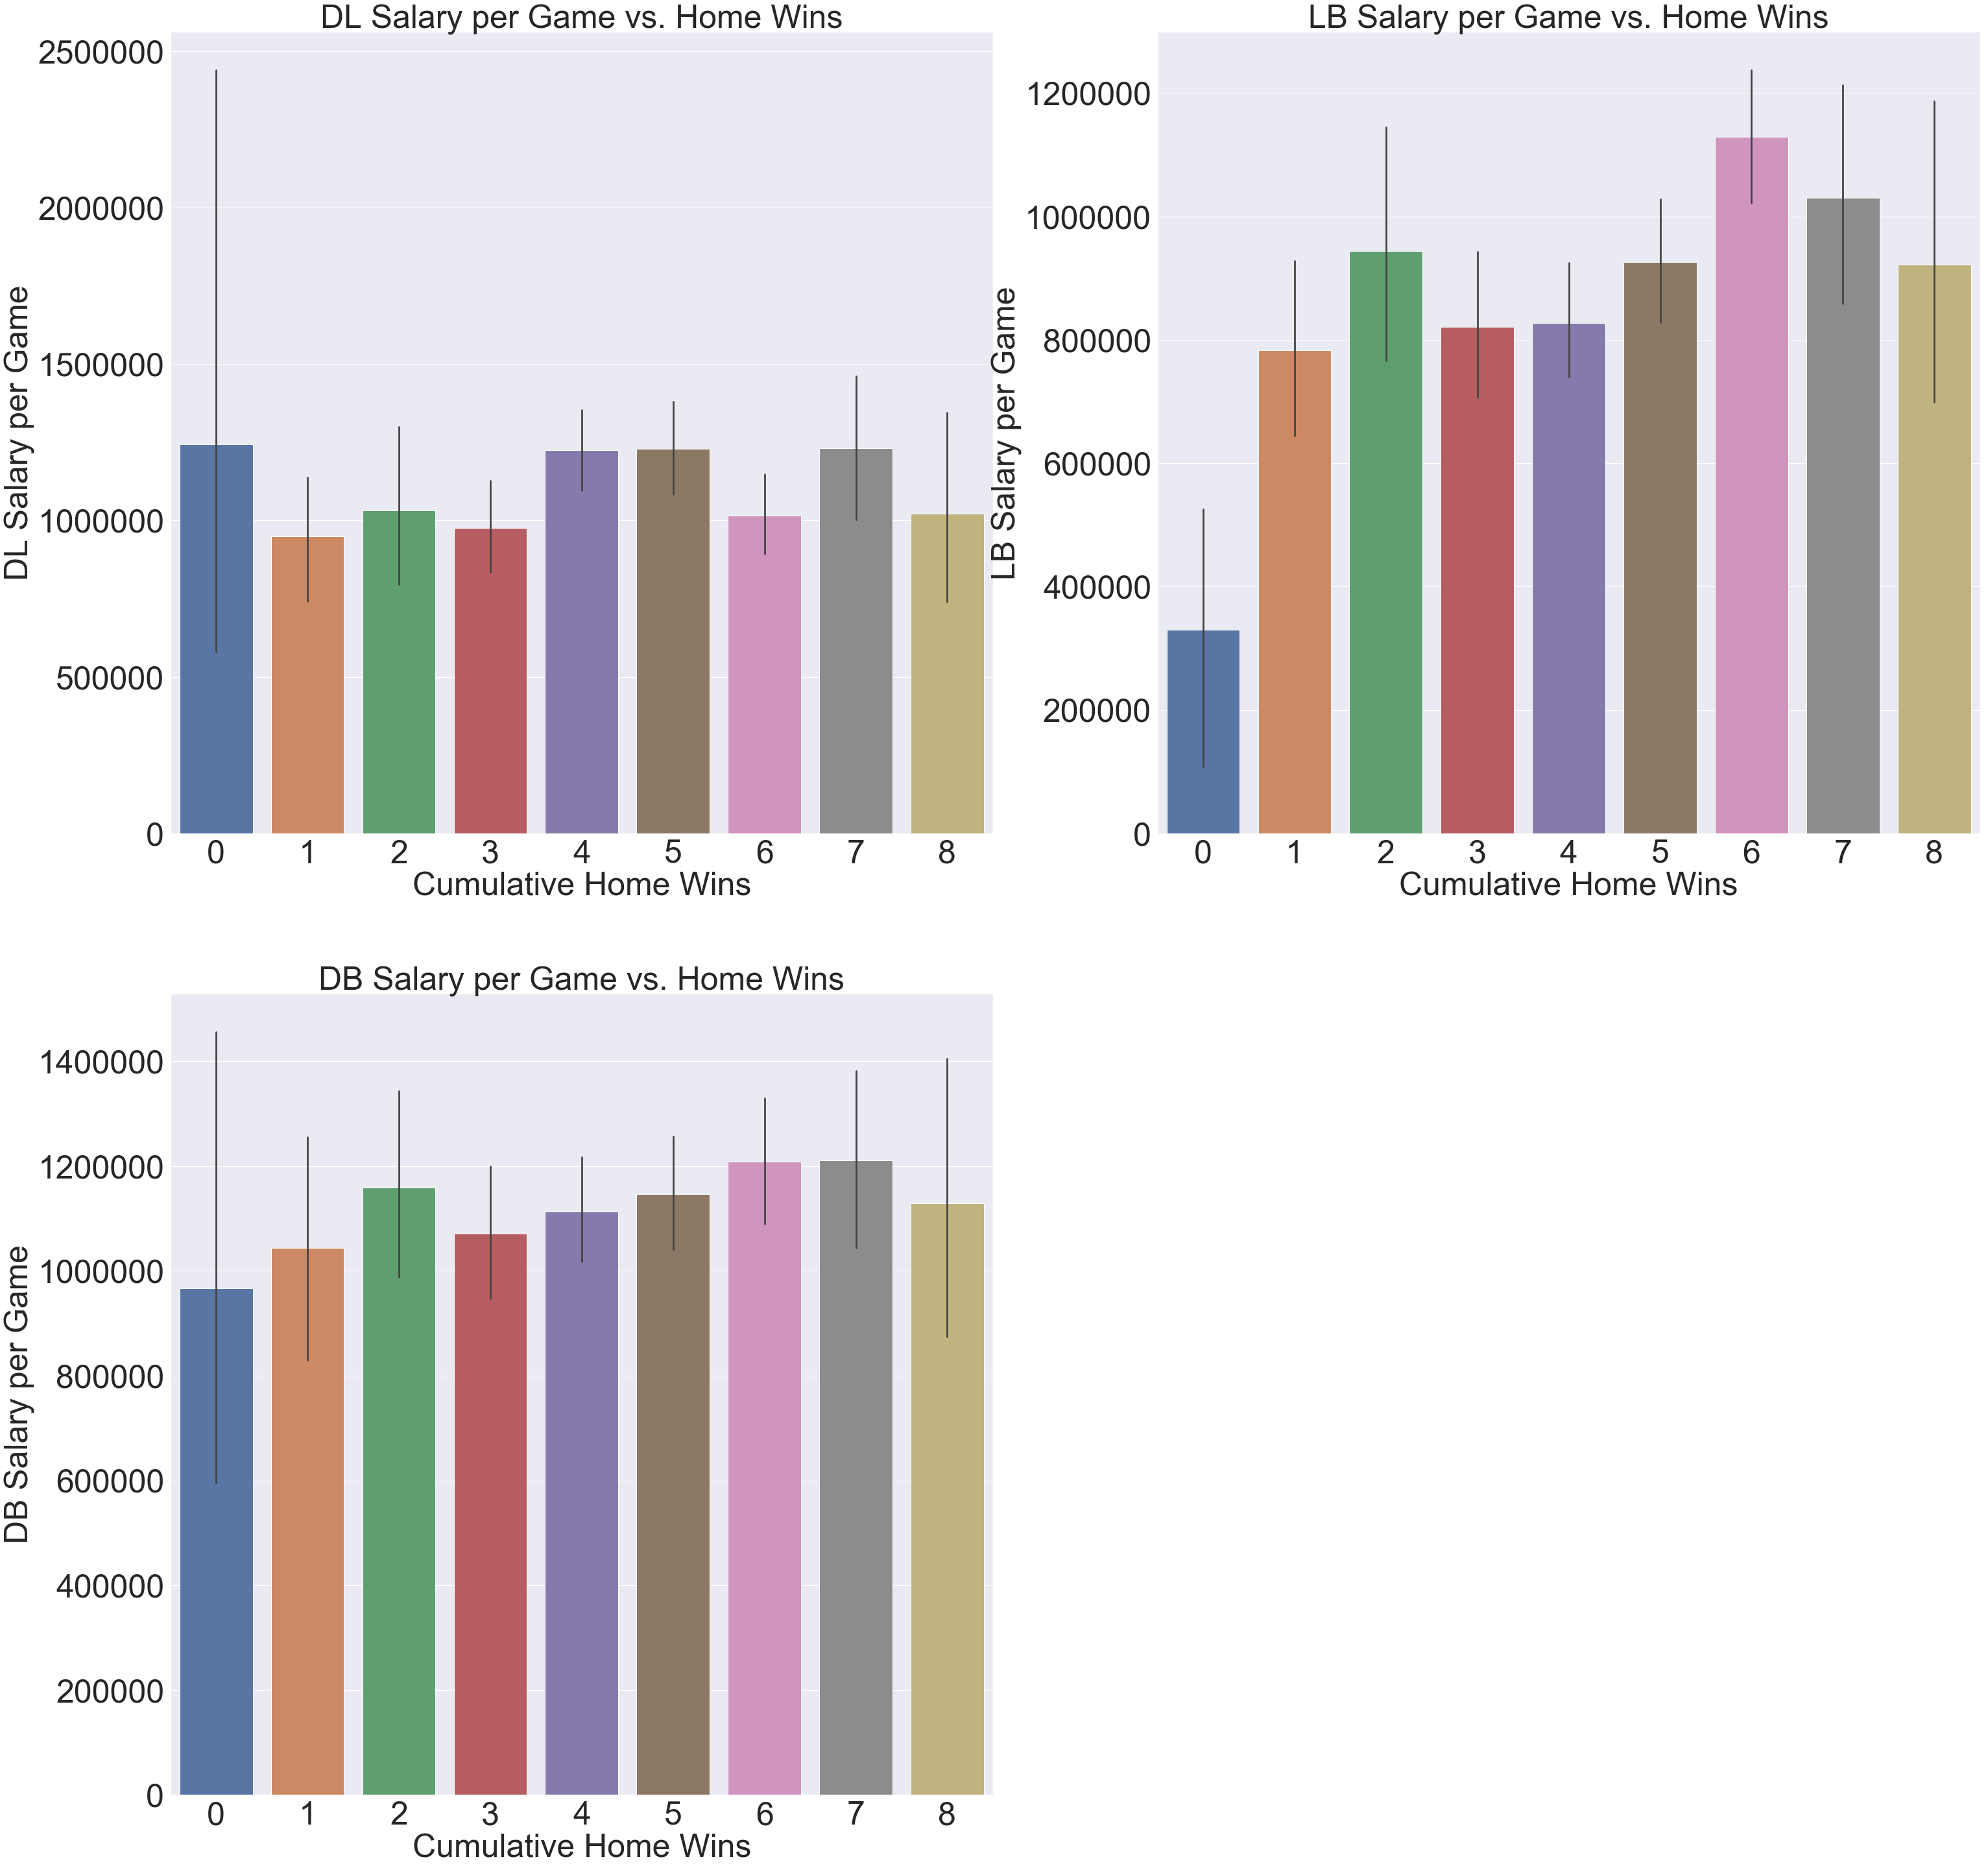

In [673]:
fig = plt.figure(figsize=(50,50))
ax21 = fig.add_subplot(221)
ax22 = fig.add_subplot(222)
ax23 = fig.add_subplot(223)

sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['DL $ Per Game'],  ax=ax21).set_title("DL Salary per Game vs. Home Wins", fontsize = 50)
ax21.set_xlabel('Cumulative Home Wins', fontsize = 50)
ax21.set_ylabel('DL Salary per Game', fontsize = 50)
ax21.tick_params(labelsize=50)

sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['LB $ Per Game'],  ax=ax22).set_title("LB Salary per Game vs. Home Wins", fontsize = 50)
ax22.set_xlabel('Cumulative Home Wins', fontsize = 50)
ax22.set_ylabel('LB Salary per Game', fontsize = 50)
ax22.tick_params(labelsize=50)

sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['DB $ Per Game'],  ax=ax23).set_title("DB Salary per Game vs. Home Wins", fontsize = 50)
ax23.set_xlabel('Cumulative Home Wins', fontsize = 50)
ax23.set_ylabel('DB Salary per Game', fontsize = 50)
ax23.tick_params(labelsize=50)

fig.savefig('img/d_salary_v_hw.png')

# Bringing it all Together

In [674]:
# create a new games dataframe from game_results
games = game_results

# rename columns
stats_od.columns=['team','year','week','yards_allowed','points_allowed','turnover_forced','first_downs','yards_gained','play_count','points','turnovers']

# merge game results with stats; there need to be two merges because both home and away teams need statistics
games=pd.merge(pd.merge(games,stats_od,left_on=['home_team','year','week'],right_on=['team','year','week']),stats_od,left_on=['away_team','year','week'],right_on=['team','year','week'],suffixes=['_home','_away'])

# comptue diffs for each variable
diffs=['yards_allowed','points_allowed','turnover_forced','first_downs','yards_gained','play_count','points','turnovers']
for i in diffs:
    diff_column = i + "_diff"
    home_column = i + "_home"
    away_column = i + "_away"
    games[diff_column] = games[home_column] - games[away_column]

# we only need the diffs, so drop all the home/away specific stats columns
home = [col for col in games if col.endswith('home')]
away = [col for col in games if col.endswith('away')]
games = games.drop(home,axis=1)
games = games.drop(away,axis=1)

In [675]:
games.head()

year  week home_team  home_score away_team  away_score  home_win  away_win  \
0  2010     3       ARI          24       OAK          23         1         0   
1  2010     5       ARI          30        NO          20         1         0   
2  2010     8       ARI          35        TB          38         0         1   
3  2010    10       ARI          18       SEA          36         0         1   
4  2010    12       ARI           6        SF          27         0         1   

   tie  Temp_F  ...  K/P/LS Salary_diff  Avg. Age_diff  yards_allowed_diff  \
0    0      70  ...        -378375.0000           0.32               130.0   
1    0      70  ...          76630.1875           0.49               240.0   
2    0      70  ...          55625.0000           2.18                98.0   
3    0      70  ...        -121187.5000           0.34                83.0   
4    0      70  ...         -11250.0000           0.62               472.0   

   points_allowed_diff  turnover_forced_diff  first_downs_diff  \
0                -10.0                   8.0             -15.0   
1                 40.0                   2.0             -23.0   
2                 34.0                  -4.0             -27.0   
3                 10.0                   3.0               1.0   
4                 50.0                  -1.0               8.0   

   yards_gained_diff  play_count_diff  points_diff  turnovers_diff  
0             -168.0            -68.0         22.0            -1.0  
1             -406.0            -70.0        -29.0             6.0  
2             -512.0            -60.0        -16.0             6.0  
3              -44.0            -50.0         18.0             4.0  
4              -25.0              1.0          8.0             4.0  

[5 rows x 37 columns]

In [676]:
games.tail()

year  week home_team  home_score away_team  away_score  home_win  \
2298  2018    13        NE          24       MIN          10         1   
2299  2018     4        NE          38       MIA           7         1   
2300  2018     9        NE          31        GB          17         1   
2301  2018    16        NE          24       BUF          12         1   
2302  2018     6        NE          43        KC          40         1   

      away_win  tie  Temp_F  ...  K/P/LS Salary_diff  Avg. Age_diff  \
2298         0    0      51  ...         289375.0000           1.50   
2299         0    0      66  ...         385679.1875           1.25   
2300         0    0      42  ...          98517.3125           2.10   
2301         0    0      37  ...         257481.6250           1.10   
2302         0    0      45  ...         298437.5000           1.50   

      yards_allowed_diff  points_allowed_diff  turnover_forced_diff  \
2298               580.0                 19.0                  -2.0   
2299               -50.0                -13.0                  -4.0   
2300               217.0                -11.0                   4.0   
2301               521.0                 16.0                  -1.0   
2302              -490.0                -18.0                   0.0   

      first_downs_diff  yards_gained_diff  play_count_diff  points_diff  \
2298              12.0              296.0             28.0         -1.0   
2299              24.0              -29.0             48.0         12.0   
2300              13.0               -6.0             30.0         45.0   
2301               5.0              168.0             11.0        -14.0   
2302             -17.0             -274.0            -24.0        -28.0   

      turnovers_diff  
2298            -3.0  
2299             0.0  
2300             4.0  
2301            -2.0  
2302             4.0  

[5 rows x 37 columns]

# Training and Testing Data
- The 2018 will be the testing data, and the previous seasons will be the training data.

In [677]:
from sklearn.model_selection import train_test_split

# create past games df that will be used to train our model
past_games = games[(games['year']!=max(games.year)) & (games['week']!=max(games_18.week))]

# create future games df that will be predicted using our trained model
future_games = games[(games['year']==max(games.year)) ]

# for statsmodels, we need to specify
past_games['intercept'] = 1.0
future_games['intercept'] = 1.0

# our training columns will be the diffs
training_cols = [col for col in games if col.endswith('diff')] + ['Temp_F', 'Dome', 'clear', 'cloudy', 'fog', 'humid', 'rain', 'snow','sunny', 'windy']
# for correlation check
for_corr = training_cols + ["home_win"]



# Correlation Matrix of the Features

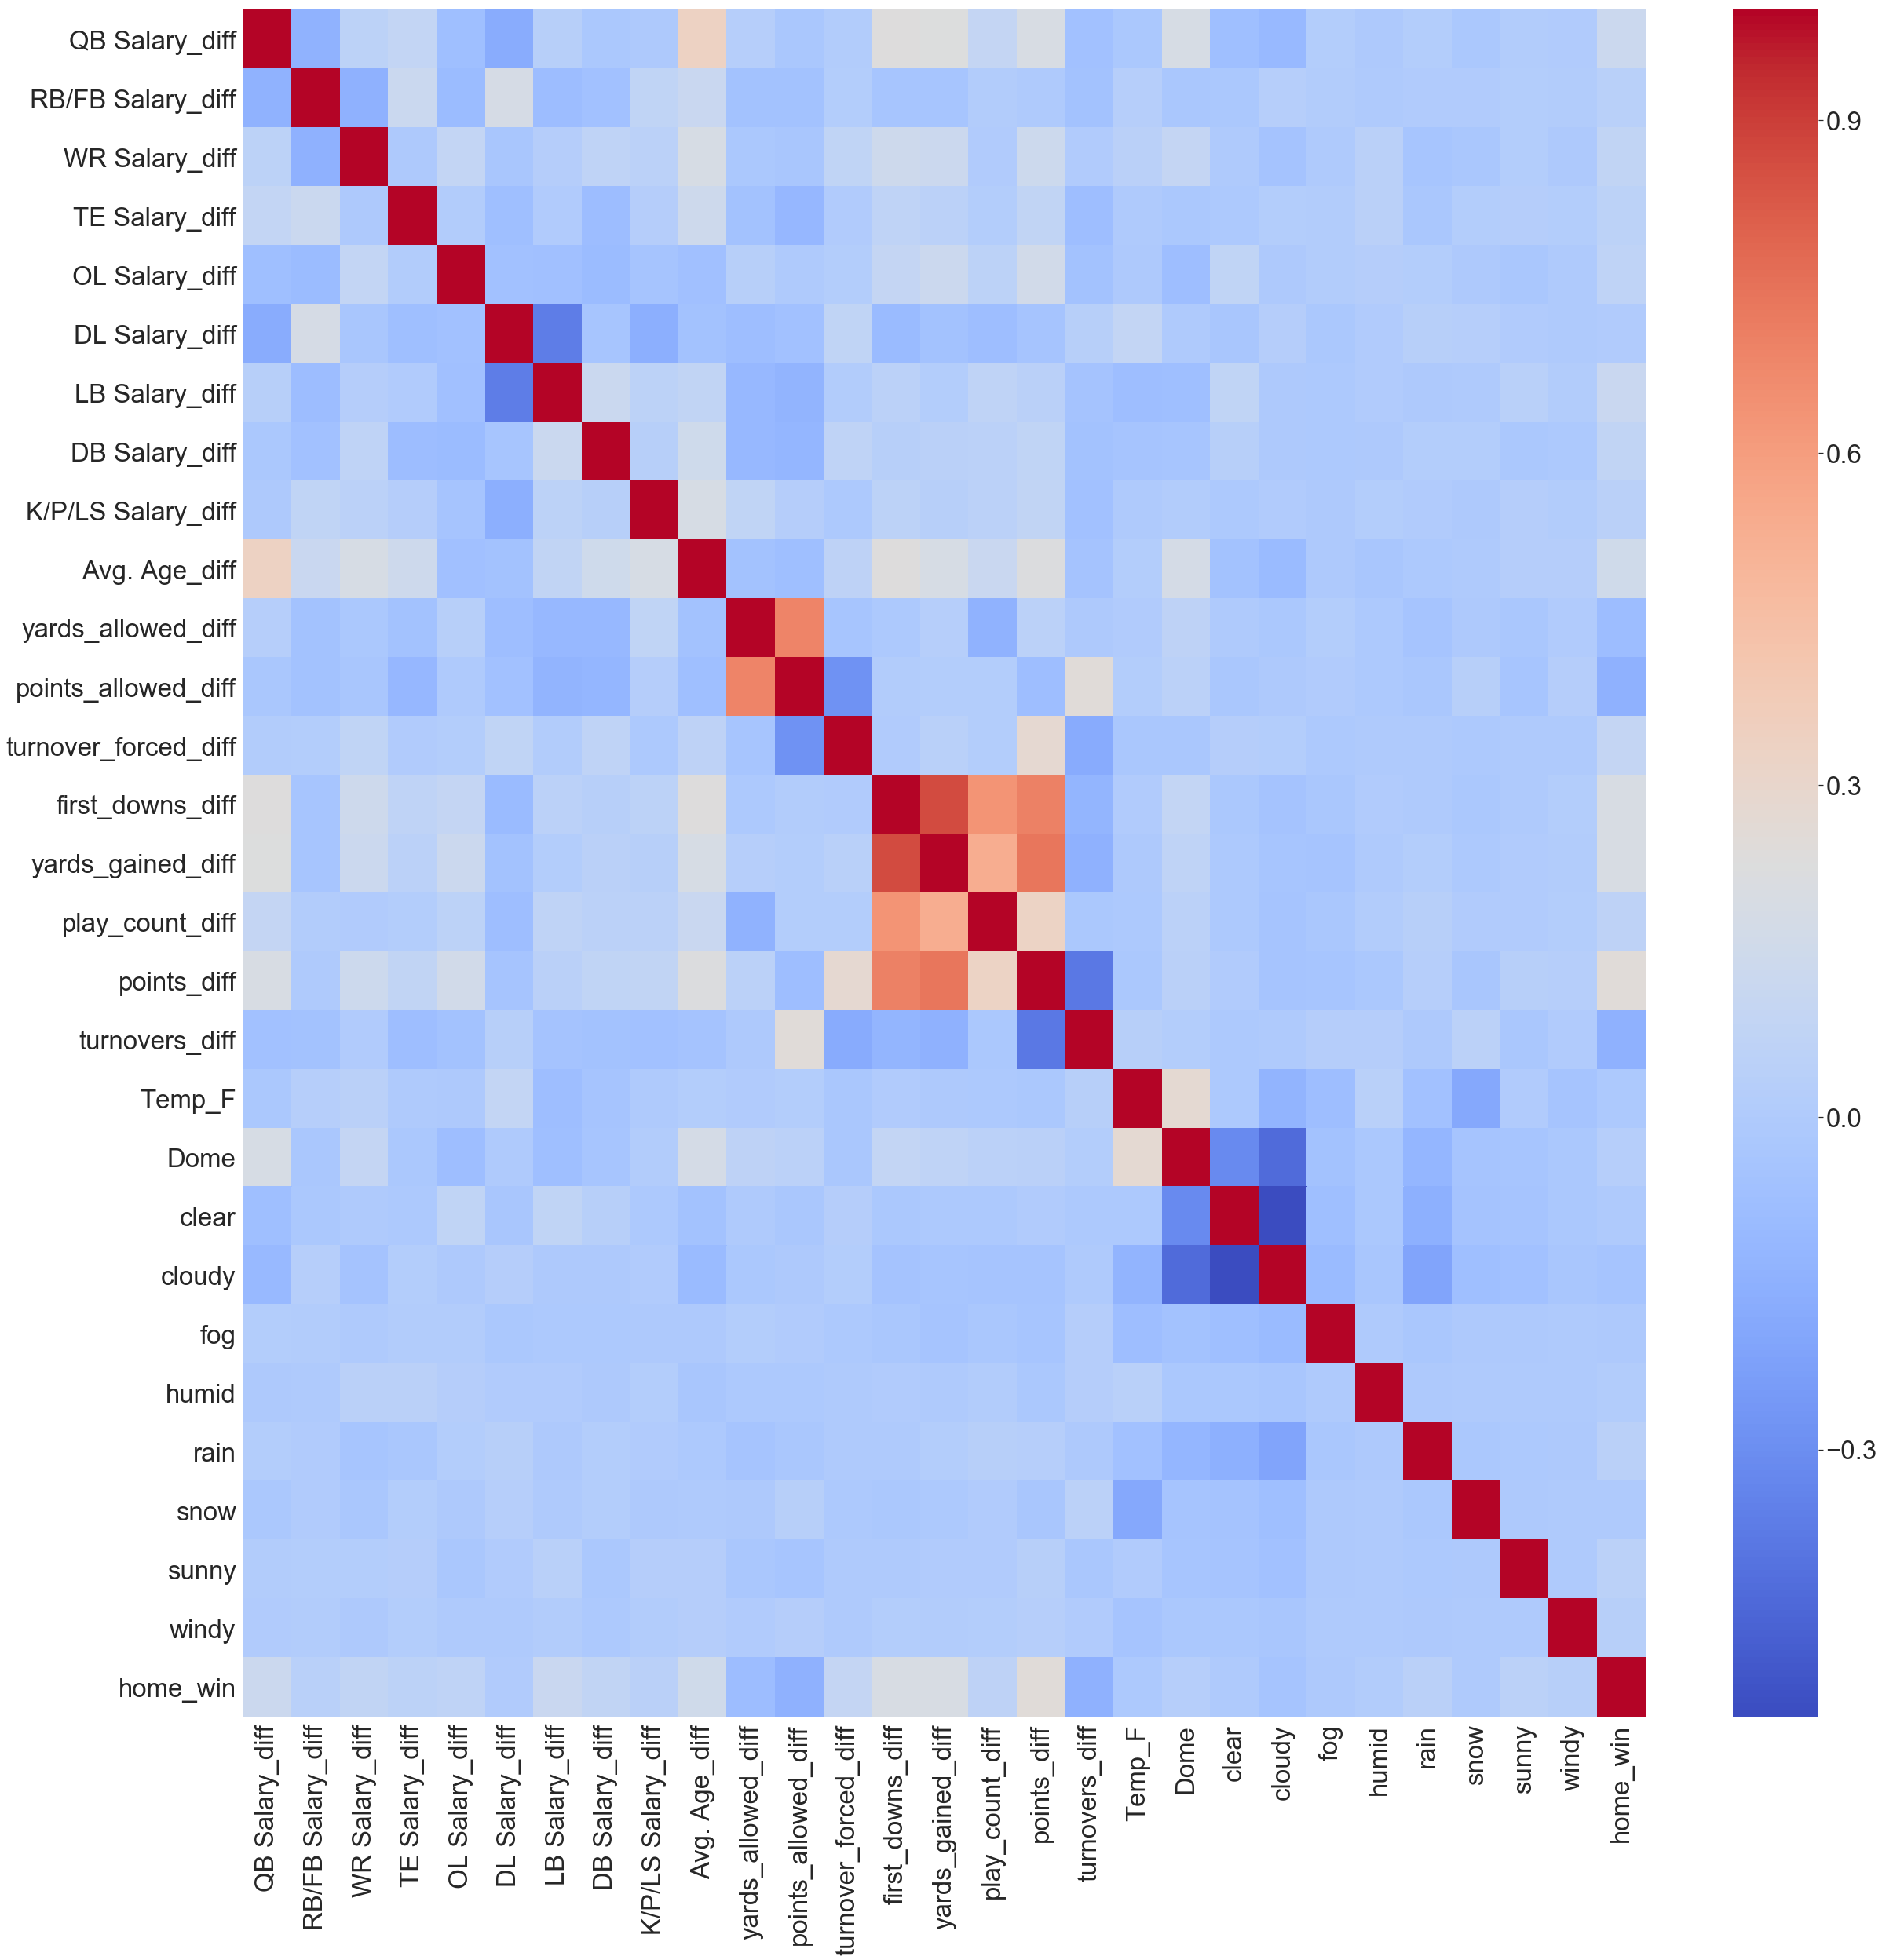

In [732]:
fig = plt.figure()
sns.set(rc={'figure.figsize':(40,40)}, font_scale=3)
sns.set(font_scale=3)
sns.heatmap(games[for_corr].corr(),cmap='coolwarm',annot=False)
fig.savefig('img/corr_map.png', bbox_inches = 'tight')

# Principal Component Analysis
- Using orthogonal transformation to converts the 28 features into a set of linearly uncorrelated varaiables called principal components.

In [679]:
from sklearn.preprocessing import StandardScaler

In [680]:
scaler = StandardScaler()
scaler.fit(past_games[training_cols])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [681]:
#Transform the data to its first 2 principal components
scaled_data = scaler.transform(past_games[training_cols])

In [682]:
from sklearn.decomposition import PCA

In [683]:
pca = PCA(n_components=2)

In [684]:
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [685]:
x_pca = pca.transform(scaled_data)
xf_pca = pca.transform(future_games[training_cols])

In [686]:
#The 28 dimensions are reduced to two.
scaled_data.shape

(1920L, 28L)

In [687]:
x_pca.shape

(1920L, 2L)

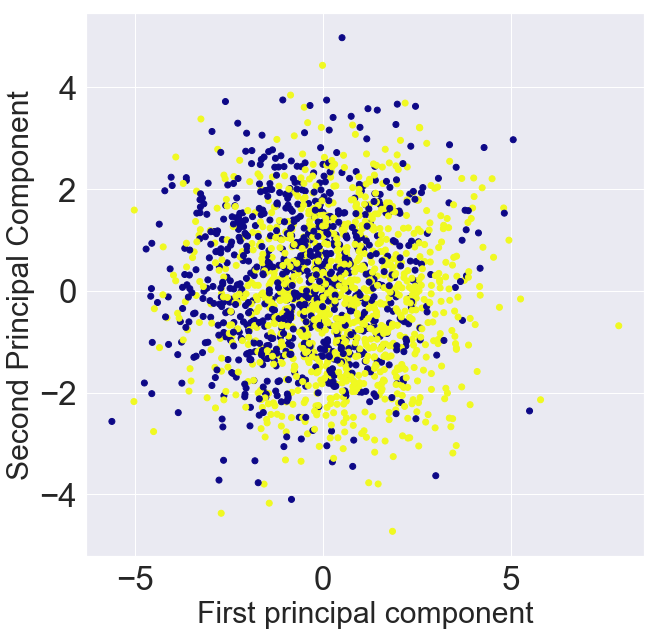

In [734]:
fig = plt.figure(figsize=(10,10))
plt.scatter(x_pca[:,0],x_pca[:,1],c=past_games['home_win'],cmap='plasma')
plt.xlabel('First principal component', fontsize=30)
plt.ylabel('Second Principal Component', fontsize=30)
fig.savefig('img/PCA1.png')

In [689]:
pca.components_

array([[ 0.20068685, -0.0274165 ,  0.11485031,  0.04530902,  0.0581821 ,
        -0.10202996,  0.07257171,  0.06551973,  0.05016748,  0.22233258,
        -0.0375608 , -0.06743217,  0.10077006,  0.49299953,  0.48242805,
         0.34998886,  0.45783845, -0.17490447,  0.00458707,  0.08561294,
        -0.01061447, -0.05864254, -0.03255085, -0.01907714,  0.01370559,
        -0.02792936,  0.01591616,  0.01678304],
       [ 0.11296009, -0.10273752,  0.01587135, -0.12244377, -0.01708905,
        -0.13755432, -0.10958603, -0.16526543,  0.08019891,  0.00199012,
         0.50240168,  0.59644927, -0.28847561,  0.09326554,  0.08334631,
         0.0412857 , -0.05111675,  0.2418134 ,  0.11327218,  0.27902966,
        -0.03681654, -0.16016205,  0.01532757, -0.04360154, -0.06808068,
         0.01394784, -0.04282359,  0.01270291]])

In [690]:
pca.explained_variance_

array([3.31752591, 2.01942724])

In [691]:
df_comp = pd.DataFrame(pca.components_,columns=training_cols)

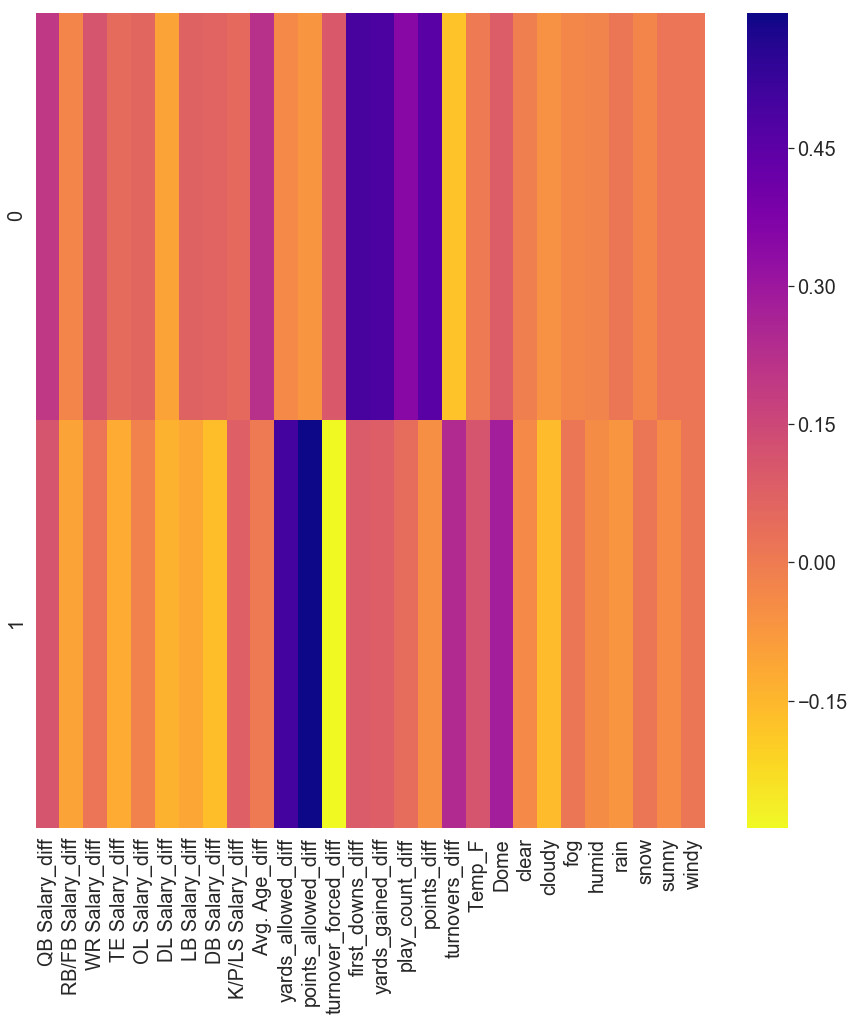

In [692]:
# This heatmap and the color bar basically represent the correlation between the various features and the principal component itself.
sns.set(rc={'figure.figsize':(15,15)}, font_scale=3)
sns.set(font_scale=1.8)
fig = sns.heatmap(df_comp,cmap='plasma_r').get_figure()
fig.savefig('img/PCA2.png', bbox_inches = 'tight')

# Modeling
- Models used were Logistic Regression, Support Vector Machine, Decision Tree, and Random Forest.
- These models were chosen because they deal with binary classification (Home Win or No Home Win)
- The best performing models were the Logistic Regression and Random Forest models.
- The models gave an accuracy of ~60% predicting home wins.
- Models could be made more robust with season data prior to 2009 and player-specific data like injury and trade.

## Logistic Regression Model

In [693]:
# import logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# specify the alphas
param_grid = {'C': np.logspace(-5, 5, 15)}

# Instantiate a logistic regression classifier: logreg
logit = LogisticRegression()

# specify five-fold cross validation logistic regression while tuning over alpha space
logit_cv = GridSearchCV(logit, param_grid, cv=5)

# fit the model
#logit_cv.fit(past_games[training_cols],past_games['home_win'])
logit_cv.fit(past_games[training_cols],past_games['home_win'])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e-05, 5.17947e-05, 2.68270e-04, 1.38950e-03, 7.19686e-03,
       3.72759e-02, 1.93070e-01, 1.00000e+00, 5.17947e+00, 2.68270e+01,
       1.38950e+02, 7.19686e+02, 3.72759e+03, 1.93070e+04, 1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

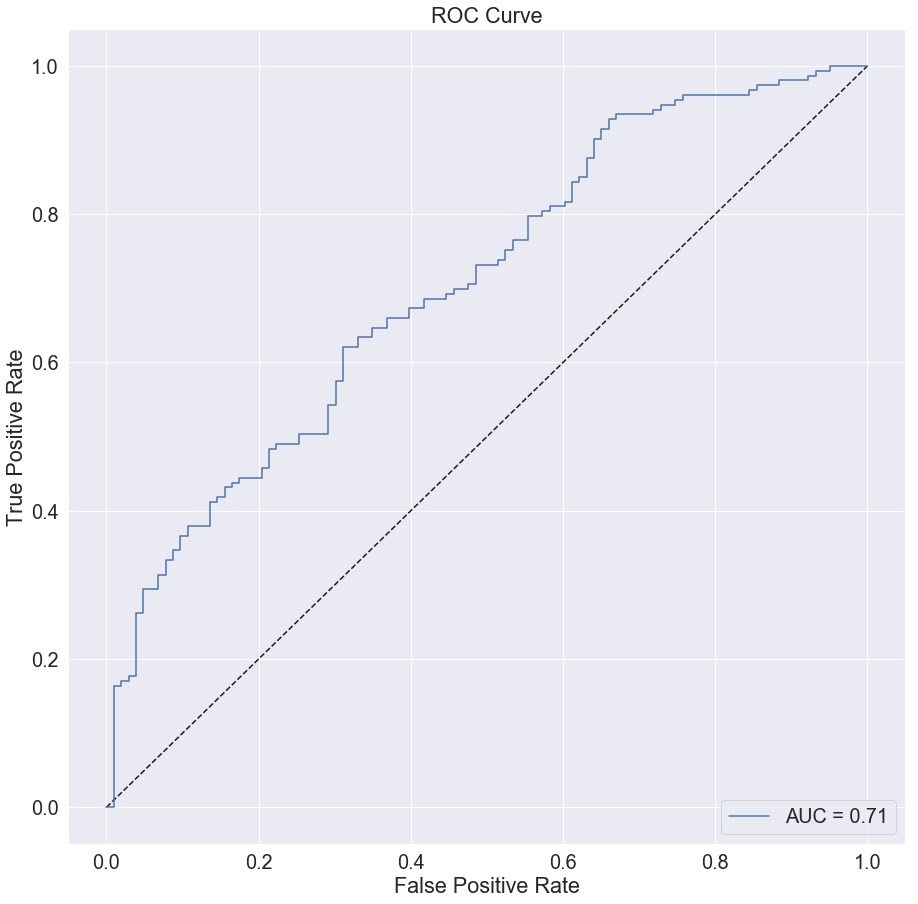

In [694]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logit_cv.predict_proba(future_games[training_cols])[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(future_games['home_win'], y_pred_prob)

#compute area under the curve
auc = metrics.auc(fpr,tpr)

# Plot ROC curve
fig = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label="AUC = %0.2f" % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
fig.savefig('img/logit_ROC.png')

In [695]:
# predict the results 
preds=logit_cv.predict(future_games[training_cols])



future_games['prediction'] = preds
future_games['Predicted_Winner'] = np.where(future_games['prediction']==1,future_games['home_team'],future_games['away_team'])
future_games['Actual_Winner'] = np.where(future_games['home_win']==1,future_games['home_team'],future_games['away_team'])
future_games['Home Win Probabiltiy %'] = logit_cv.predict_proba(future_games[training_cols])[:,1]*100.00


logit_future_games = future_games[['year','week','home_team','away_team','Home Win Probabiltiy %','Predicted_Winner','Actual_Winner']].sort_values(['week'])

logit_future_games['cum_pred_home_wins'] = (logit_future_games['Predicted_Winner'] == logit_future_games['home_team'])*1
logit_future_games['Cumulative Predicted Home Wins'] = logit_future_games.groupby('home_team').cum_pred_home_wins.cumsum()

logit_future_games['act_pred_home_wins'] = (logit_future_games['Actual_Winner'] == logit_future_games['home_team'])*1
logit_future_games['Cumulative Actual Home Wins'] = logit_future_games.groupby('home_team').act_pred_home_wins.cumsum()

logit_future_games = logit_future_games.drop(columns = ['cum_pred_home_wins','act_pred_home_wins'])

items = sorted(future_games['week'].unique().tolist())

def view(Week):
    display(logit_future_games[logit_future_games['week'] == Week])

w = widgets.Dropdown(options=items)
logit_plot = interact(view, Week=w)



aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnV2VlaycsIG9wdGlvbnM9KDFMLCAyTCwgM0wsIDRMLCA1TCwgNkwsIDdMLCA4TCwgOUwsIDEwTCwgMTFMLCAxMkzigKY=


In [696]:
#Predictions are the columns
#Actual is the rows
print(classification_report(future_games['home_win'],preds))

              precision    recall  f1-score   support

           0       0.55      0.50      0.52       103
           1       0.68      0.73      0.71       153

   micro avg       0.64      0.64      0.64       256
   macro avg       0.62      0.61      0.61       256
weighted avg       0.63      0.64      0.63       256



In [697]:
print(confusion_matrix(future_games['home_win'],preds))

[[ 51  52]
 [ 41 112]]


In [698]:
print(accuracy_score(future_games['home_win'], preds))

0.63671875


## Support Vector Machine Model

In [699]:
#import Support Vector Machine
from sklearn.svm import SVC 
svc_model = SVC(probability=True)
svc_model.fit(past_games[training_cols],past_games['home_win'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [700]:
#Model Evaluation
predictions = svc_model.predict(future_games[training_cols])

In [701]:
print(confusion_matrix(future_games['home_win'], predictions))

[[  0 103]
 [  0 153]]


In [702]:
print(classification_report(future_games['home_win'], predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       103
           1       0.60      1.00      0.75       153

   micro avg       0.60      0.60      0.60       256
   macro avg       0.30      0.50      0.37       256
weighted avg       0.36      0.60      0.45       256



In [703]:
#Gridsearch
param_grid = {'C': np.logspace(-5, 5, 15)} 
grid = GridSearchCV(SVC(probability=True), param_grid, refit=True, verbose=3)

In [704]:
grid.fit(past_games[training_cols], past_games['home_win'])

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] C=1e-05 .........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... C=1e-05, score=0.563182527301, total=   0.4s
[CV] C=1e-05 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ......................... C=1e-05, score=0.5640625, total=   0.4s
[CV] C=1e-05 .........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] ..................... C=1e-05, score=0.56338028169, total=   0.4s
[CV] C=5.1794746792312125e-05 ........................................
[CV] ... C=5.1794746792312125e-05, score=0.563182527301, total=   0.4s
[CV] C=5.1794746792312125e-05 ........................................
[CV] ........ C=5.1794746792312125e-05, score=0.5640625, total=   0.4s
[CV] C=5.1794746792312125e-05 ........................................
[CV] .... C=5.1794746792312125e-05, score=0.56338028169, total=   0.4s
[CV] C=0.0002682695795279727 .........................................
[CV] .... C=0.0002682695795279727, score=0.563182527301, total=   0.4s
[CV] C=0.0002682695795279727 .........................................
[CV] ......... C=0.0002682695795279727, score=0.5640625, total=   0.4s
[CV] C=0.0002682695795279727 .........................................
[CV] ..... C=0.0002682695795279727, score=0.56338028169, total=   0.4s
[CV] C=0.0013894954943731374 .........................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   32.6s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e-05, 5.17947e-05, 2.68270e-04, 1.38950e-03, 7.19686e-03,
       3.72759e-02, 1.93070e-01, 1.00000e+00, 5.17947e+00, 2.68270e+01,
       1.38950e+02, 7.19686e+02, 3.72759e+03, 1.93070e+04, 1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [705]:
grid.best_params_

{'C': 1e-05}

In [706]:
grid.best_estimator_

SVC(C=1e-05, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

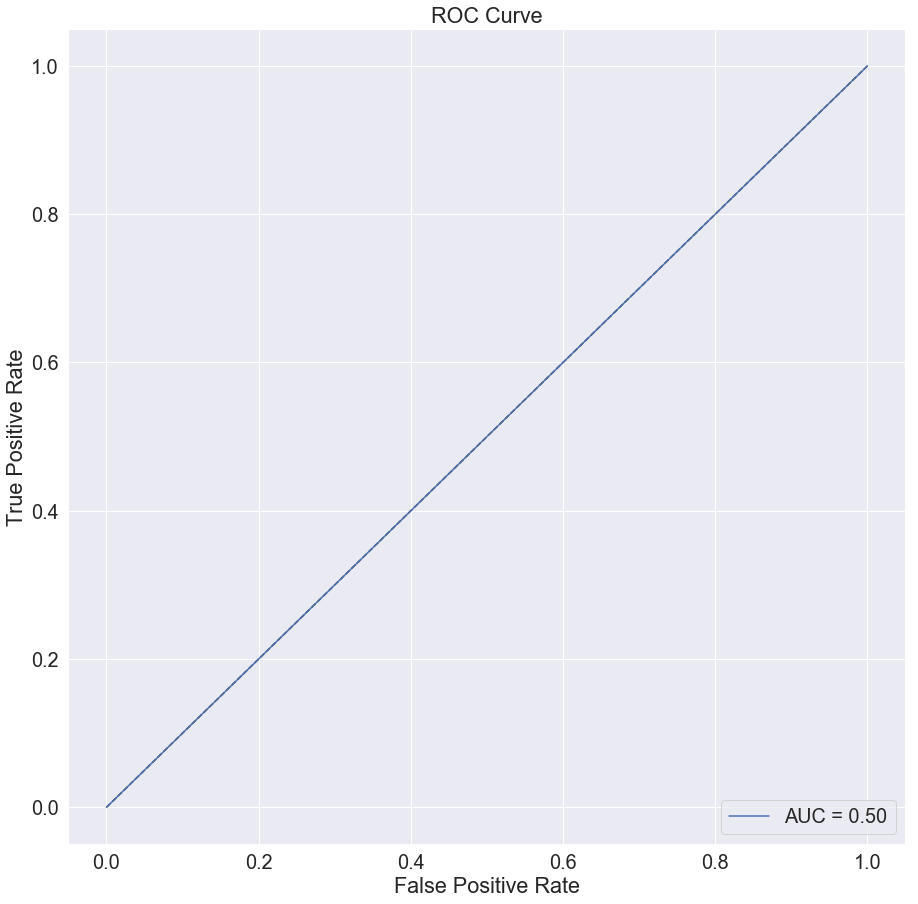

In [707]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob_svm = grid.predict_proba(future_games[training_cols])[:,1]


# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(future_games['home_win'], y_pred_prob_svm)

#compute area under the curve
auc = metrics.auc(fpr,tpr)

# Plot ROC curve
fig = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label="AUC = %0.2f" % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
fig.savefig('img/svm_ROC.png')

In [708]:
preds=grid.predict(future_games[training_cols])


future_games['prediction'] = preds
future_games['Predicted_Winner'] = np.where(future_games['prediction']==1,future_games['home_team'],future_games['away_team'])
future_games['Actual_Winner'] = np.where(future_games['home_win']==1,future_games['home_team'],future_games['away_team'])
future_games['Home Win Probabiltiy %'] = grid.predict_proba(future_games[training_cols])[:,1]*100

svc_future_games = future_games[['year','week','home_team','away_team','Home Win Probabiltiy %','Predicted_Winner','Actual_Winner']].sort_values(['week'])

svc_future_games['cum_pred_home_wins'] = (svc_future_games['Predicted_Winner'] == svc_future_games['home_team'])*1
svc_future_games['Cumulative Predicted Home Wins'] = svc_future_games.groupby('home_team').cum_pred_home_wins.cumsum()

svc_future_games['act_pred_home_wins'] = (svc_future_games['Actual_Winner'] == svc_future_games['home_team'])*1
svc_future_games['Cumulative Actual Home Wins'] = svc_future_games.groupby('home_team').act_pred_home_wins.cumsum()

svc_future_games = svc_future_games.drop(columns = ['cum_pred_home_wins','act_pred_home_wins'])


items = sorted(future_games['week'].unique().tolist())


def view(Week):
    display(svc_future_games[svc_future_games['week'] == Week])

w = widgets.Dropdown(options=items)
svc_plot = interact(view, Week=w)


aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnV2VlaycsIG9wdGlvbnM9KDFMLCAyTCwgM0wsIDRMLCA1TCwgNkwsIDdMLCA4TCwgOUwsIDEwTCwgMTFMLCAxMkzigKY=


In [709]:
print(classification_report(future_games['home_win'], predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       103
           1       0.60      1.00      0.75       153

   micro avg       0.60      0.60      0.60       256
   macro avg       0.30      0.50      0.37       256
weighted avg       0.36      0.60      0.45       256



In [710]:
print(confusion_matrix(future_games['home_win'], predictions))

[[  0 103]
 [  0 153]]


In [711]:
print(accuracy_score(future_games['home_win'], predictions))

0.59765625


## Decision Tree Model

In [712]:
#import Decision Tree
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()

In [713]:
dtree.fit(past_games[training_cols], past_games['home_win'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

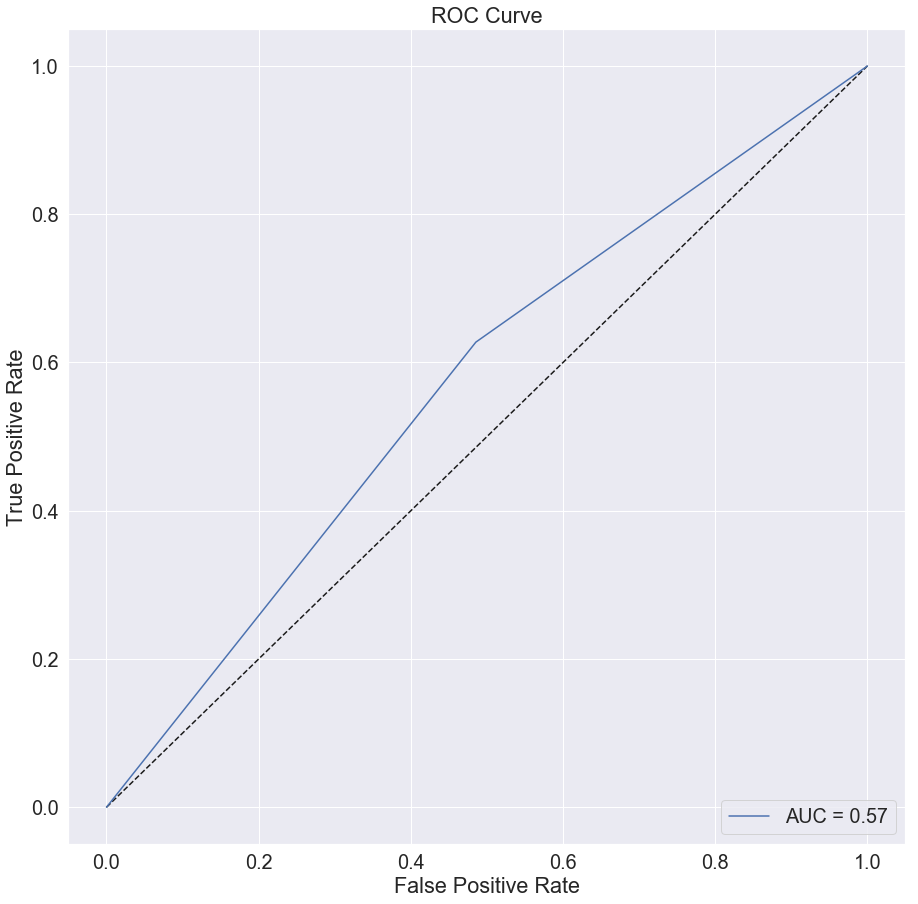

In [714]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob_dtree = dtree.predict_proba(future_games[training_cols])[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(future_games['home_win'], y_pred_prob_dtree)

#compute area under the curve
auc = metrics.auc(fpr,tpr)

# Plot ROC curve
fig = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label="AUC = %0.2f" % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
fig.savefig('img/dtree_ROC.png')

In [715]:
predictions = dtree.predict(future_games[training_cols])

In [716]:

future_games['prediction'] = predictions
future_games['Predicted_Winner'] = np.where(future_games['prediction']==1,future_games['home_team'],future_games['away_team'])
future_games['Actual_Winner'] = np.where(future_games['home_win']==1,future_games['home_team'],future_games['away_team'])
future_games['Home Win Probabiltiy %'] = dtree.predict_proba(future_games[training_cols])[:,1]

dtree_future_games = future_games[['year','week','home_team','away_team','Home Win Probabiltiy %','Predicted_Winner','Actual_Winner']].sort_values(['week'])

dtree_future_games['cum_pred_home_wins'] = (dtree_future_games['Predicted_Winner'] == dtree_future_games['home_team'])*1
dtree_future_games['Cumulative Predicted Home Wins'] = dtree_future_games.groupby('home_team').cum_pred_home_wins.cumsum()

dtree_future_games['act_pred_home_wins'] = (dtree_future_games['Actual_Winner'] == dtree_future_games['home_team'])*1
dtree_future_games['Cumulative Actual Home Wins'] = dtree_future_games.groupby('home_team').act_pred_home_wins.cumsum()

dtree_future_games = dtree_future_games.drop(columns = ['cum_pred_home_wins','act_pred_home_wins'])

items = sorted(future_games['week'].unique().tolist())

def view(Week):
    display(dtree_future_games[dtree_future_games['week'] == Week])

w = widgets.Dropdown(options=items)
dtree_plot = interact(view, Week=w)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnV2VlaycsIG9wdGlvbnM9KDFMLCAyTCwgM0wsIDRMLCA1TCwgNkwsIDdMLCA4TCwgOUwsIDEwTCwgMTFMLCAxMkzigKY=


In [717]:
from sklearn.metrics import classification_report,confusion_matrix

In [718]:
print(classification_report(future_games['home_win'], predictions))

              precision    recall  f1-score   support

           0       0.48      0.51      0.50       103
           1       0.66      0.63      0.64       153

   micro avg       0.58      0.58      0.58       256
   macro avg       0.57      0.57      0.57       256
weighted avg       0.59      0.58      0.58       256



In [719]:
print(confusion_matrix(future_games['home_win'], predictions))

[[53 50]
 [57 96]]


In [720]:
print(accuracy_score(future_games['home_win'], predictions))

0.58203125


In [721]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 

features = training_cols



In [722]:
dot_data = StringIO()  
export_graphviz(dtree, out_file=dot_data,feature_names=features,filled=True,rounded=True)

(graph,) = pydot.graph_from_dot_data(dot_data.getvalue())  
tree_fig = Image(graph.create_png())
graph.write_png('img/tree_fig.png')

In [723]:
tree_fig

## Random Forest Model

In [724]:
# import Random Forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(past_games[training_cols], past_games['home_win'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

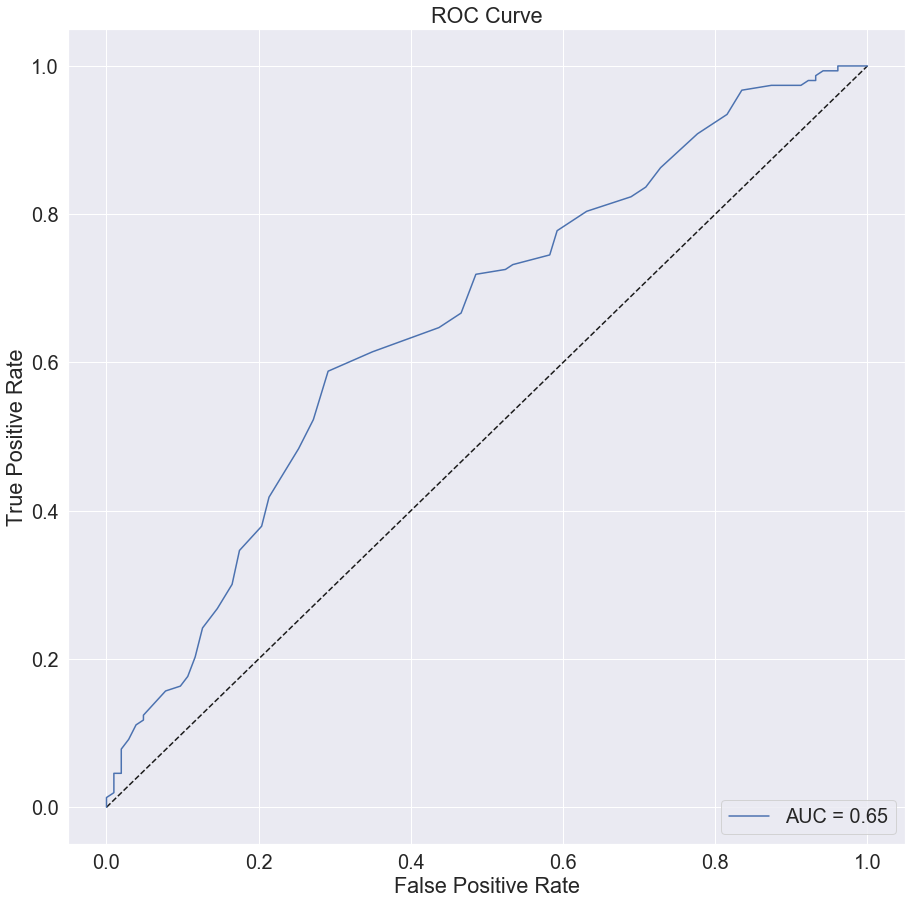

In [725]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob_rfc = rfc.predict_proba(future_games[training_cols])[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(future_games['home_win'], y_pred_prob_rfc)

#compute area under the curve
auc = metrics.auc(fpr,tpr)

# Plot ROC curve
fig = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label="AUC = %0.2f" % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
fig.savefig('img/rfc_ROC.png')

In [726]:
rfc_pred = rfc.predict(future_games[training_cols])

In [727]:

future_games['prediction'] = rfc_pred
future_games['Predicted_Winner'] = np.where(future_games['prediction']==1,future_games['home_team'],future_games['away_team'])
future_games['Actual_Winner'] = np.where(future_games['home_win']==1,future_games['home_team'],future_games['away_team'])
future_games['Home Win Probability %'] = rfc.predict_proba(future_games[training_cols])[:,1]

rfc_future_games = future_games[['year','week','home_team','away_team','Home Win Probabiltiy %','Predicted_Winner','Actual_Winner']].sort_values(['week'])

rfc_future_games['cum_pred_home_wins'] = (rfc_future_games['Predicted_Winner'] == rfc_future_games['home_team'])*1
rfc_future_games['Cumulative Predicted Home Wins'] = rfc_future_games.groupby('home_team').cum_pred_home_wins.cumsum()

rfc_future_games['act_pred_home_wins'] = (rfc_future_games['Actual_Winner'] == rfc_future_games['home_team'])*1
rfc_future_games['Cumulative Actual Home Wins'] = rfc_future_games.groupby('home_team').act_pred_home_wins.cumsum()

rfc_future_games = rfc_future_games.drop(columns = ['cum_pred_home_wins','act_pred_home_wins'])

items = sorted(future_games['week'].unique().tolist())

def view(Week):
    display(rfc_future_games[rfc_future_games['week'] == Week])

w = widgets.Dropdown(options=items)
rfc_plot = interact(view, Week=w)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnV2VlaycsIG9wdGlvbnM9KDFMLCAyTCwgM0wsIDRMLCA1TCwgNkwsIDdMLCA4TCwgOUwsIDEwTCwgMTFMLCAxMkzigKY=


In [728]:
print(classification_report(future_games['home_win'],rfc_pred))

              precision    recall  f1-score   support

           0       0.54      0.47      0.50       103
           1       0.67      0.73      0.70       153

   micro avg       0.62      0.62      0.62       256
   macro avg       0.60      0.60      0.60       256
weighted avg       0.62      0.62      0.62       256



In [729]:
print(confusion_matrix(future_games['home_win'],rfc_pred))

[[ 48  55]
 [ 41 112]]


In [730]:
print(accuracy_score(future_games['home_win'], rfc_pred))

0.625
